In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import re
from scipy.stats import chi2_contingency
from sklearn import linear_model
import sklearn.tree as tree
import sklearn.tree
from IPython.display import Image  
import pydotplus
import nltk
from nltk.corpus import opinion_lexicon
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [2]:
df = pd.read_csv("okcupid_profiles.csv")

Mandate fields while creating account- 

* Age
* Status
* Sex
* Orientation


We have *prefer not to say* option in the following field(columns) - 
* Body Type
* Height
* Languages
* Ethnicity
* Religion
* Education
* Employment /Jobs
* Sign
* Drinks
* Smoking
* Drugs
* Diet
* Children


Multiple Choices with *prefer not to say* option - 
* Pets
* Languages / Speaks
* Ethnicity

# Initial Data Exploration

### NaN Counts

In [3]:
nan_counts = df.isna().sum()

In [4]:
nan_counts

age                0
status             0
sex                0
orientation        0
body_type       5296
diet           24395
drinks          2985
drugs          14080
education       6628
ethnicity       5680
height             3
income             0
job             8198
last_online        0
location           0
offspring      35561
pets           19921
religion       20226
sign           11056
smokes          5512
speaks            50
essay0          5488
essay1          7572
essay2          9638
essay3         11476
essay4         10537
essay5         10850
essay6         13771
essay7         12451
essay8         19225
essay9         12603
dtype: int64

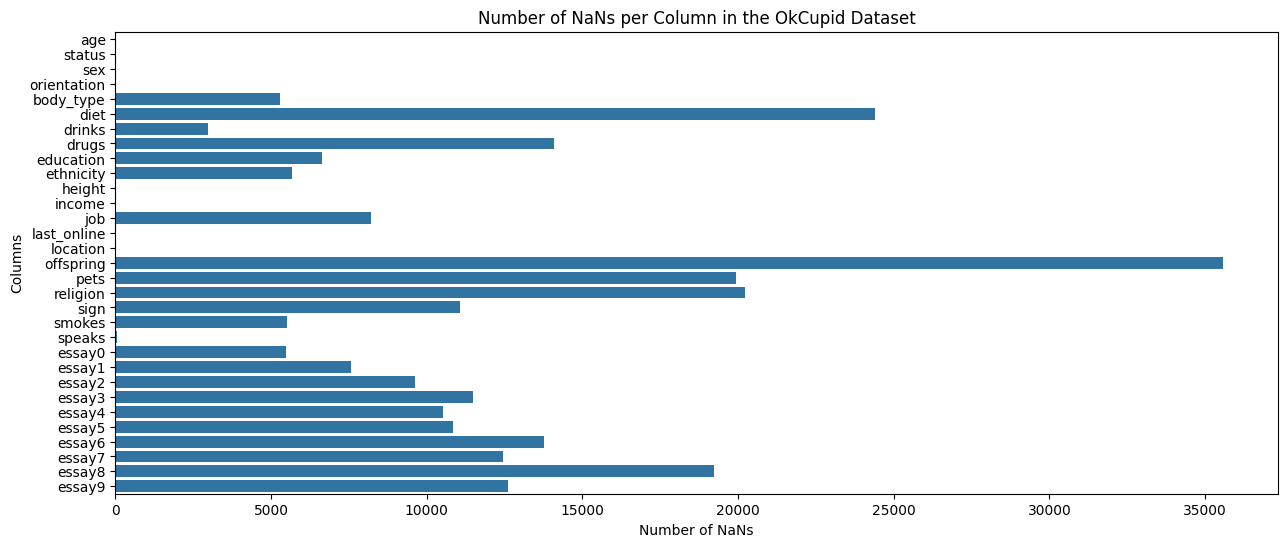

In [5]:
plt.figure(figsize=(15, 6))
sns.barplot(x=nan_counts.values, y=nan_counts.index)
plt.title('Number of NaNs per Column in the OkCupid Dataset')
plt.xlabel('Number of NaNs')
plt.ylabel('Columns')
plt.show()

### Age Distribution

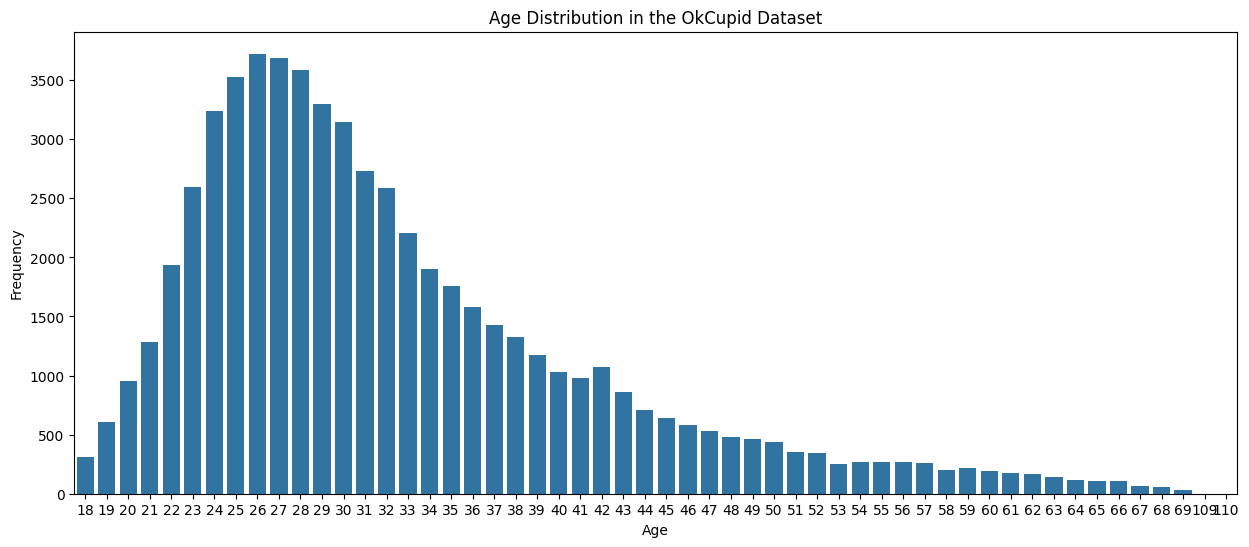

In [6]:
age_counts = df['age'].value_counts().sort_index()

# Creating the plot for 'age'
plt.figure(figsize=(15, 6))
sns.barplot(x=age_counts.index, y=age_counts.values)
plt.title('Age Distribution in the OkCupid Dataset')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

### Income NaN = -1

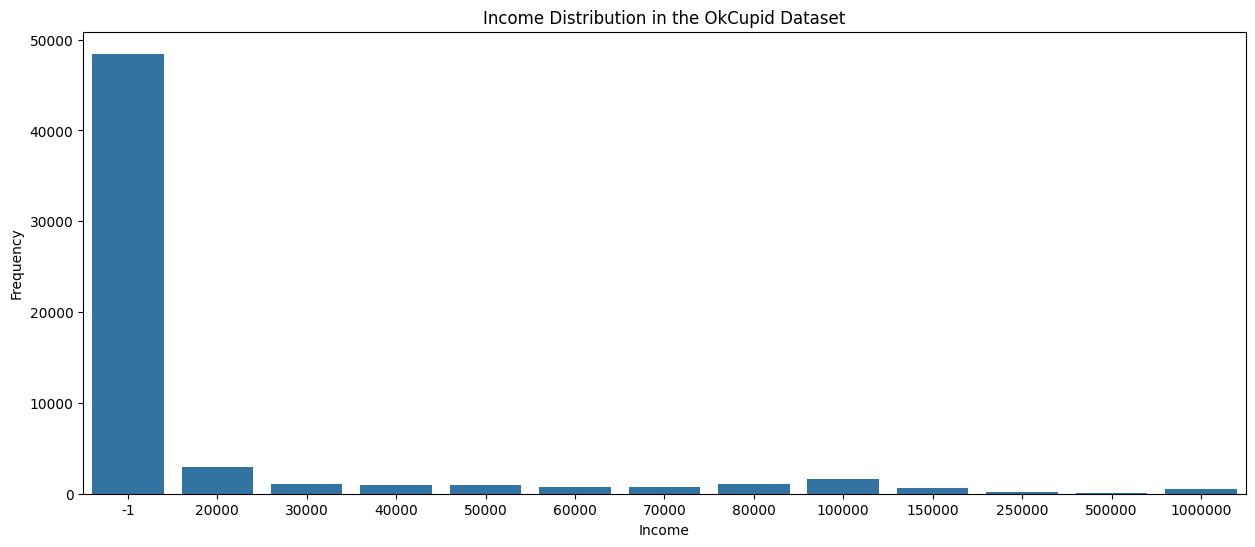

In [7]:
income_counts = df['income'].value_counts().sort_index()

# Creating the plot for 'income'
plt.figure(figsize=(15, 6))
sns.barplot(x=income_counts.index, y=income_counts.values)
plt.title('Income Distribution in the OkCupid Dataset')
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.show()

# Dealing with NaNs and Outliers

In [8]:
df_clean = df.copy()

Dropping rows with age outliers

In [9]:
df_clean = df_clean[df_clean['age'] <= 69]

Filling NaN height with median values

In [10]:
mask = df.height.isna()
df_clean.loc[mask,'height'] = df_clean.height.median()

Replace -1 in income with 0

In [11]:
df_clean.income.replace(-1,0, inplace = True)

Drop rows where all essay responses are NaN. We intend to do sentiment analysis and these rows will not be useful

In [12]:
rows_to_drop = df_clean[['essay0', 'essay1', 'essay2','essay3','essay4','essay5','essay6','essay7','essay8','essay9']].isna().all(axis=1)
print(rows_to_drop.sum())
df_clean = df_clean.drop(df_clean[rows_to_drop].index)

2123


Drop "last_online" column. The information is not useful.

In [13]:
df_clean = df_clean.drop(columns = "last_online")

Replace all other NaN values with "unknown"

In [14]:
non_essay_columns = [col for col in df_clean.columns if not col.startswith('essay')]

df_clean[non_essay_columns] = df_clean[non_essay_columns].fillna("unknown")

In [15]:
nan_counts = df_clean.isna().sum()

In [16]:
nan_counts

age                0
status             0
sex                0
orientation        0
body_type          0
diet               0
drinks             0
drugs              0
education          0
ethnicity          0
height             0
income             0
job                0
location           0
offspring          0
pets               0
religion           0
sign               0
smokes             0
speaks             0
essay0          3363
essay1          5447
essay2          7513
essay3          9352
essay4          8412
essay5          8725
essay6         11646
essay7         10326
essay8         17100
essay9         10478
dtype: int64

# Reduce Dimensionality

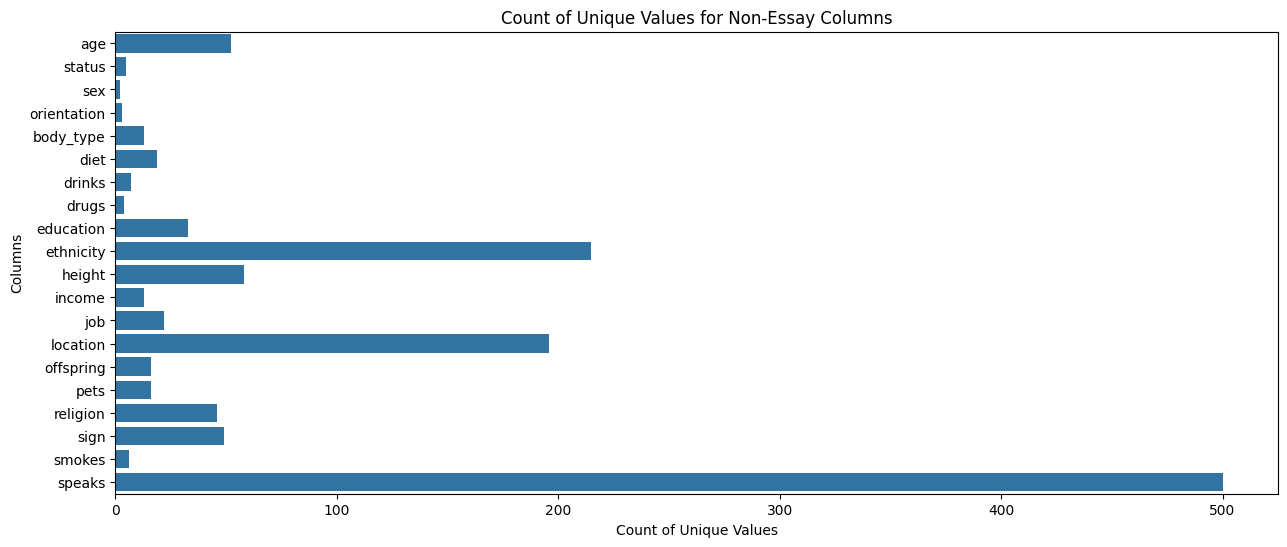

In [17]:
non_essay_columns = df_clean.columns[~df_clean.columns.str.startswith('essay')]

unique_value_counts = df_clean[non_essay_columns].nunique().clip(upper=500)

plt.figure(figsize=(15, 6))
sns.barplot(x=unique_value_counts.values, y=unique_value_counts.index)
plt.title('Count of Unique Values for Non-Essay Columns')
plt.xlabel('Count of Unique Values')
plt.ylabel('Columns')
plt.show()

### Body_type

In [18]:
body_type_mapping = {
    'a little extra': 'overweight',
    'overweight': 'overweight',
    'average': 'curvy',
    'curvy': 'curvy',
    'full figured': 'curvy',
    'thin': 'skinny',
    'skinny': 'skinny',
    'fit': 'athletic',
    'athletic': 'athletic',
    'jacked': 'athletic',
    'rather not say': 'rather not say',
    'used up': 'rather not say',
    'unknown' : 'unkown'
}

In [19]:
df_clean['body_type'] = df_clean['body_type'].map(body_type_mapping)

### Diet

In [20]:
diet_mapping = {
    'strictly anything': 'omnivore',
    'anything':'omnivore',
    'mostly other': 'omnivore',
    'mostly anything': 'omnivore',
    'mostly vegetarian': 'omnivore',
    'mostly vegan': 'vegetarian',
    'vegetarian': 'vegetarian',
    'strictly vegetarian': 'vegetarian',
    'strictly vegan': 'vegan',
    'vegan': 'vegan',
    'strictly other': 'other',
    'other' : 'other',
    'mostly halal': 'other',
    'mostly kosher': 'other',
    'strictly halal': 'other',
    'halal': 'other',
    'strictly kosher': 'other',
    'kosher': 'other',
    'unknown': 'unknown'
}

In [21]:
df_clean['diet'] = df_clean['diet'].map(diet_mapping)

### Drinks

In [22]:
drink_mapping = {
    'not at all': 1,  #make it 1
    'rarely': 2,
    'socially': 3,
    'often': 4,
    'very often': 5,
    'desperately': 6,
    'unknown': 0
}

In [23]:
df_clean['drinks'] = df_clean['drinks'].map(drink_mapping)

### Drugs

In [24]:
drugs_mapping = {
    'never': 1,
    'sometimes': 2,
    'often': 3,
    'unknown': 0
}

In [25]:
df_clean['drugs'] = df_clean['drugs'].map(drugs_mapping)

### Education

In [26]:
education_mapping = {
    'graduated from college/university': 'Undergraduate',
    'graduated from masters program': 'Graduate',
    'working on college/university': 'Undergraduate',
    'working on masters program': 'Graduate',
    'graduated from two-year college': 'Associate',
    'graduated from high school': 'High School',
    'graduated from ph.d program': 'Professional',
    'graduated from law school': 'Professional',
    'working on two-year college': 'Associate',
    'dropped out of college/university': 'High School',
    'working on ph.d program': 'Postgraduate',
    'college/university': 'Undergraduate',
    'graduated from space camp': 'unknown',
    'dropped out of space camp': 'unknown',
    'graduated from med school': 'Professional',
    'working on space camp': 'unknown',
    'working on law school': 'Professional',
    'two-year college': 'Associate',
    'working on med school': 'Professional',
    'dropped out of two-year college': 'Associate',
    'dropped out of masters program': 'Undergraduate',
    'masters program': 'Graduate',
    'dropped out of ph.d program': 'Graduate',
    'dropped out of high school': 'High School',
    'high school': 'High School',
    'working on high school': 'Professional',
    'space camp': 'unknown',
    'ph.d program': 'Postgraduate',
    'law school': 'Professional',
    'dropped out of law school': 'High School',
    'dropped out of med school': 'High School',
    'med school': 'Professional',
    'unknown': 'unknown'
}

In [27]:
df_clean['education'] = df_clean['education'].map(education_mapping)

### Ethnicity

In [28]:
ethnicity_mapping = {
    'white': 'White',
    'asian': 'Asian',
    'black': 'Black',
    'hispanic / latin': 'Hispanic/Latin',
    'pacific islander': 'Pacific Islander',
    'middle eastern': 'Middle Eastern',
    'native american': 'Native American',
    'indian': 'Indian',
    'other': 'Other',
    'mixed': 'Mixed', 
    'unknown': 'unknown' 
}

In [29]:
# Function to classify ethnicities
def classify_ethnicity(eth):
    if pd.isna(eth) or eth == 'nan':
        return 'unknown'
    eth_split = eth.split(', ')
    if len(eth_split) == 1:
        return ethnicity_mapping.get(eth_split[0], 'Other')
    else:
        return 'Mixed' 

In [30]:
df_clean['ethnicity'] = df_clean['ethnicity'].apply(classify_ethnicity)

### Job

In [31]:
job_mapping = {
    'transportation': 'Blue Collar',
    'hospitality / travel': 'Service',
    'student': 'Student',
    'artistic / musical / writer': 'Creative',
    'computer / hardware / software': 'Tech',
    'banking / financial / real estate': 'Finance',
    'entertainment / media': 'Entertainment',
    'sales / marketing / biz dev': 'Sales',
    'other': 'unknown',
    'medicine / health': 'Healthcare',
    'science / tech / engineering': 'STEM',
    'executive / management': 'Management',
    'education / academia': 'Education',
    'clerical / administrative': 'Admin',
    'construction / craftsmanship': 'Blue Collar',
    'rather not say': 'unknown',
    'political / government': 'Government',
    'law / legal services': 'Legal',
    'unemployed': 'Unemployed',
    'military': 'Military',
    'retired': 'Retired',
    'unknown': 'unknown'
}

In [32]:
df_clean['job'] = df_clean['job'].map(job_mapping)

### Offspring

In [33]:
offspring_mapping = {
    "doesn't have kids, but might want them": 'Might Want Kids',
    'unknown': 'unknown',
    "doesn't want kids": 'No Kids',
    "doesn't have kids, but wants them": 'Might Want Kids',
    "doesn't have kids": 'No Kids',  
    'wants kids': 'Wants Kids',
    "has kids, and wants more": 'Wants More Kids',
    "has a kid, and wants more": 'Wants More Kids',
    'might want kids': 'Might Want Kids',
    'has kids, and might want more': 'Might Want Kids',  
    'has a kid': 'Has Kids',
    'has kids': 'Has Kids',
    "doesn't have kids, and doesn't want any": 'No Kids',
    "has kids, but doesn't want more": 'Has Kids',
    "has a kid, but doesn't want more": 'Has Kids',
    'has a kid, and might want more': 'Wants More Kids', 
    'has kids, and wants more': 'Wants More Kids'
}

In [34]:
df_clean['offspring'] = df_clean['offspring'].map(offspring_mapping)

### Pets

In [35]:
pet_mapping = {
    'likes dogs and likes cats': 'likes cats & dogs',
    'likes dogs and has cats': 'likes cats & dogs',
    'has dogs and has cats': 'likes cats & dogs',
    'has dogs and likes cats': 'likes cats & dogs',
    'has dogs': 'likes dogs',
    'has cats': 'likes cats',
    'likes dogs': 'likes dogs',
    'has dogs and dislikes cats': 'dislikes cats',
    'likes dogs and dislikes cats': 'dislikes cats',
    'dislikes cats': 'dislikes cats',
    'dislikes dogs and likes cats': 'dislikes dogs',
    'dislikes dogs and has cats': 'dislikes dogs',
    'dislikes dogs': 'dislikes dogs',
    'dislikes dogs and dislikes cats': 'dislikes dogs & cats',
    'unknown': 'unknown',
    'likes cats': 'likes cats'
}

In [36]:
df_clean['pets'] = df_clean['pets'].map(pet_mapping)

### Religion

In [37]:
religion_mapping = {'unknown': 'unknown',
    'agnosticism but not too serious about it': 'agnosticism',
    'agnosticism': 'agnosticism',
    'agnosticism and laughing about it': 'agnosticism',
    'catholicism but not too serious about it': 'catholicism',
    'other': 'other',
    'atheism': 'atheism',
    'atheism and laughing about it': 'atheism',
    'other and laughing about it': 'other',
    'christianity but not too serious about it': 'christianity',
    'christianity': 'christianity',
    'judaism but not too serious about it': 'judaism',
    'other but not too serious about it': 'other',
    'atheism but not too serious about it': 'atheism',
    'catholicism': 'catholicism',
    'atheism and somewhat serious about it': 'atheism',
    'judaism and laughing about it': 'judaism',
    'catholicism and laughing about it': 'catholicism',
    'christianity and somewhat serious about it': 'christianity',
    'other and somewhat serious about it': 'other',
    'buddhism but not too serious about it': 'buddhism',
    'judaism': 'judaism',
    'agnosticism and somewhat serious about it': 'agnosticism',
    'catholicism and somewhat serious about it': 'catholicism',
    'atheism and very serious about it': 'atheism',
    'buddhism and laughing about it': 'buddhism',
    'christianity and very serious about it': 'christianity',
    'other and very serious about it': 'other',
    'christianity and laughing about it': 'christianity',
    'buddhism': 'buddhism',
    'buddhism and somewhat serious about it': 'buddhism',
    'agnosticism and very serious about it': 'agnosticism',
    'judaism and somewhat serious about it': 'judaism',
    'hinduism but not too serious about it': 'hinduism',
    'hinduism': 'hinduism',
    'catholicism and very serious about it': 'catholicism',
    'buddhism and very serious about it': 'buddhism',
    'hinduism and somewhat serious about it': 'hinduism',
    'islam but not too serious about it': 'islam',
    'hinduism and laughing about it': 'hinduism',
    'islam': 'islam', 
    'islam and very serious about it': 'islam',
    'judaism and very serious about it': 'judaism',
    'islam and somewhat serious about it': 'islam',
    'islam and laughing about it': 'islam',
    'hinduism and very serious about it': 'hinduism'}

In [38]:
df_clean['religion'] = df_clean['religion'].map(religion_mapping)

### Sign

In [39]:
sign_mapping = {'unknown': 'unknown',
    'gemini and it&rsquo;s fun to think about': 'gemini',
    'taurus and it&rsquo;s fun to think about': 'taurus',
    'scorpio and it&rsquo;s fun to think about': 'scorpio',
    'leo and it&rsquo;s fun to think about': 'leo',
    'libra and it&rsquo;s fun to think about': 'libra',
    'virgo and it&rsquo;s fun to think about': 'virgo',
    'virgo but it doesn&rsquo;t matter': 'virgo',
    'taurus but it doesn&rsquo;t matter': 'taurus',
    'aries and it&rsquo;s fun to think about': 'aries',
    'cancer and it&rsquo;s fun to think about': 'cancer',
    'pisces and it&rsquo;s fun to think about': 'pisces',
    'gemini but it doesn&rsquo;t matter': 'gemini',
    'sagittarius and it&rsquo;s fun to think about': 'sagittarius',
    'cancer but it doesn&rsquo;t matter': 'cancer',
    'aquarius but it doesn&rsquo;t matter': 'aquarius',
    'libra but it doesn&rsquo;t matter': 'libra',
    'aquarius and it&rsquo;s fun to think about': 'aquarius',
    'leo but it doesn&rsquo;t matter': 'leo',
    'sagittarius but it doesn&rsquo;t matter': 'sagittarius',
    'aries but it doesn&rsquo;t matter': 'aries',
    'capricorn but it doesn&rsquo;t matter': 'capricorn',
    'pisces but it doesn&rsquo;t matter': 'pisces',
    'capricorn and it&rsquo;s fun to think about': 'capricorn',
    'scorpio but it doesn&rsquo;t matter': 'scorpio',
    'leo': 'leo',
    'libra': 'libra',
    'cancer': 'cancer',
    'virgo': 'virgo',
    'gemini': 'gemini',
    'pisces': 'pisces',
    'scorpio': 'scorpio',
    'taurus': 'taurus',
    'aries': 'aries',
    'sagittarius': 'sagittarius',
    'aquarius': 'aquarius',
    'capricorn': 'capricorn',
    'scorpio and it matters a lot': 'scorpio',
    'pisces and it matters a lot': 'pisces',
    'cancer and it matters a lot': 'cancer',
    'leo and it matters a lot': 'leo',
    'gemini and it matters a lot': 'gemini',
    'capricorn and it matters a lot': 'capricorn',
    'sagittarius and it matters a lot': 'sagittarius',
    'aries and it matters a lot': 'aries',
    'libra and it matters a lot': 'libra',
    'aquarius and it matters a lot': 'aquarius',
    'taurus and it matters a lot': 'taurus',
    'virgo and it matters a lot': 'virgo'}

In [40]:
df_clean['sign'] = df_clean['sign'].map(sign_mapping)

### Smokes

In [41]:
smoke_mapping = {
    "unknown": 0,
    "no": 1,
    "trying to quit": 2,
    "sometimes": 2,
    "when drinking": 2,
    "yes": 3
    
}

In [42]:
df_clean['smokes'] = df_clean['smokes'].map(smoke_mapping)

# Data Exploration Continued

### Sex Distribution

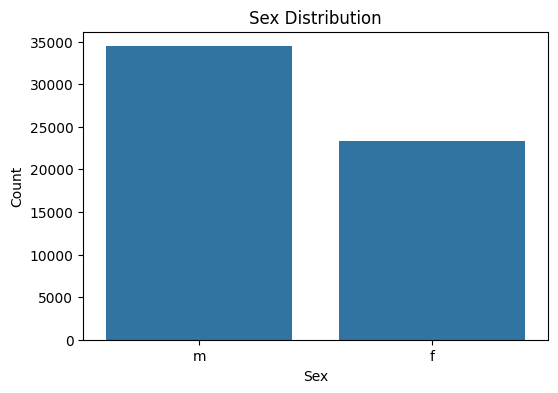

In [43]:
plt.figure(figsize=(6, 4))
sns.countplot(x='sex', data=df_clean)
plt.title('Sex Distribution')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()

### Orientation Distribution

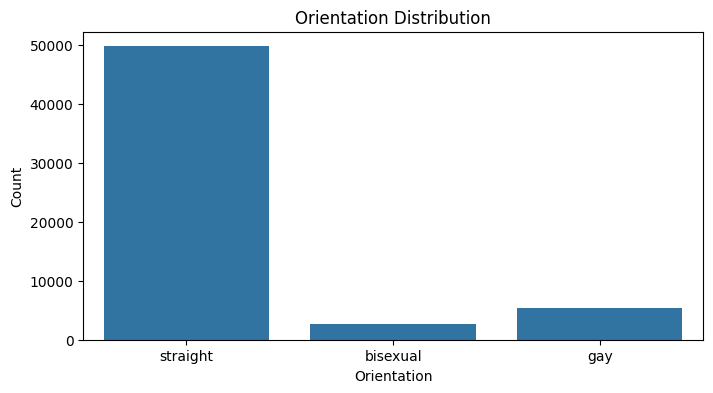

In [44]:
plt.figure(figsize=(8, 4))
sns.countplot(x='orientation', data=df_clean)
plt.title('Orientation Distribution')
plt.xlabel('Orientation')
plt.ylabel('Count')
plt.show()

### Ethnicity Distribution

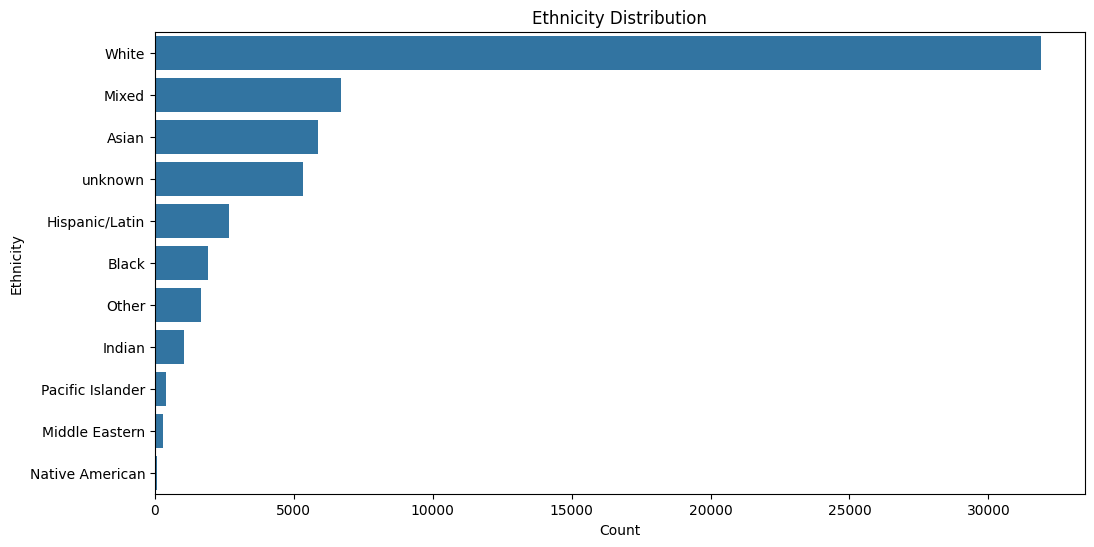

In [45]:
plt.figure(figsize=(12, 6))
sns.countplot(y='ethnicity', data=df_clean, order = df_clean['ethnicity'].value_counts().index)
plt.title('Ethnicity Distribution')
plt.xlabel('Count')
plt.ylabel('Ethnicity')
plt.show()

### Religion Distribution

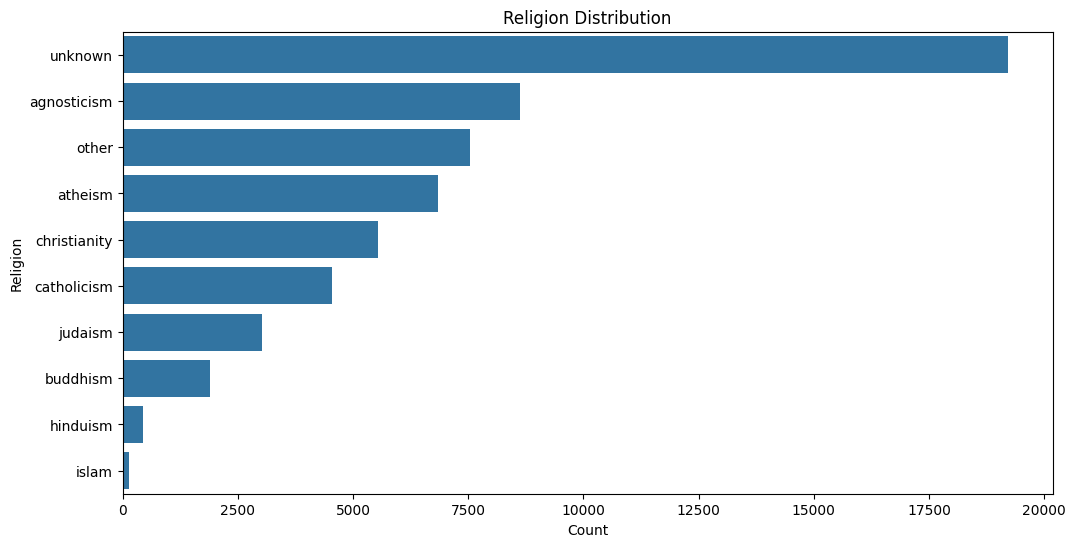

In [46]:
plt.figure(figsize=(12, 6))
sns.countplot(y='religion', data=df_clean, order = df_clean['religion'].value_counts().index)
plt.title('Religion Distribution')
plt.xlabel('Count')
plt.ylabel('Religion')
plt.show()

### Body Type Distribution

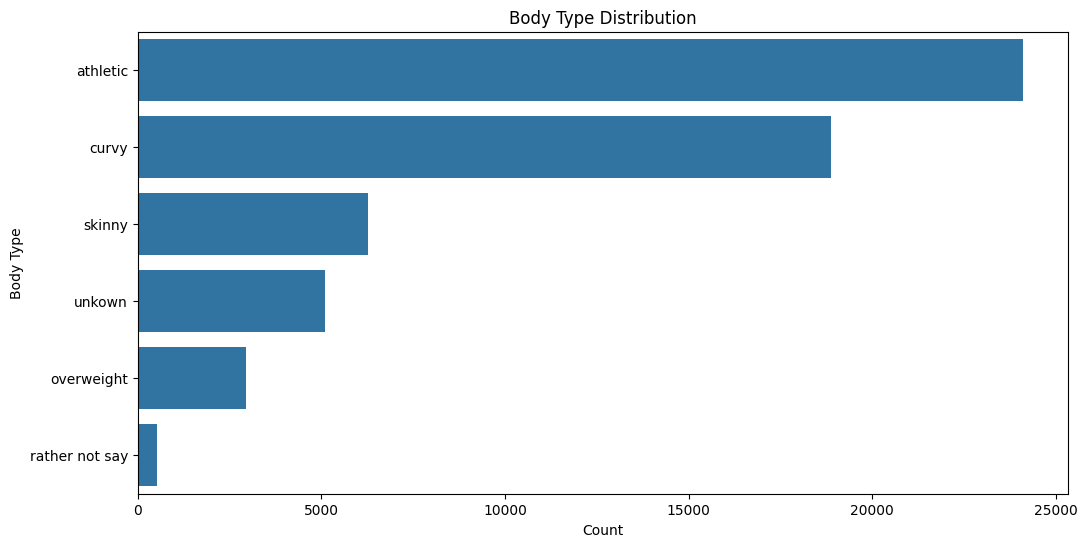

In [47]:
plt.figure(figsize=(12, 6))
sns.countplot(y='body_type', data=df_clean, order = df_clean['body_type'].value_counts().index)
plt.title('Body Type Distribution')
plt.xlabel('Count')
plt.ylabel('Body Type')
plt.show()

### Language Distribution

In [48]:
#Extract Languages
def extract_languages(speaks_str):
    languages = re.sub(r'\([^)]*\)', '', speaks_str)
    return [lang.strip() for lang in languages.split(',')]

In [49]:
language_counts = Counter()
df_clean['speaks'].apply(lambda x: language_counts.update(extract_languages(x)))

0        None
1        None
2        None
3        None
4        None
         ... 
59941    None
59942    None
59943    None
59944    None
59945    None
Name: speaks, Length: 57821, dtype: object

In [50]:
#Prep for plotting
most_common_languages = language_counts.most_common(10)
languages, counts = zip(*most_common_languages)

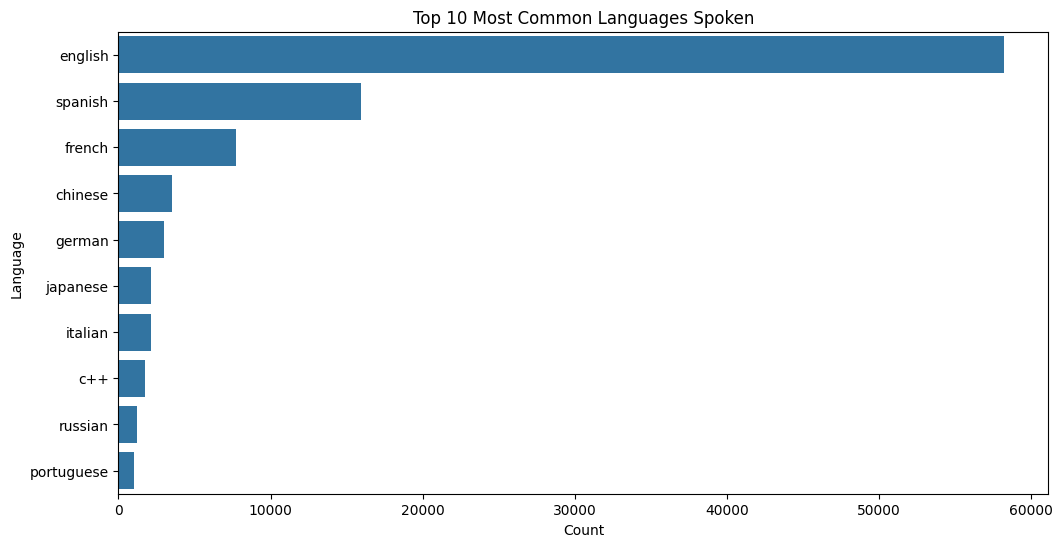

In [51]:
# Creating the countplot
plt.figure(figsize=(12, 6))
sns.barplot(x=list(counts), y=list(languages))
plt.title('Top 10 Most Common Languages Spoken')
plt.xlabel('Count')
plt.ylabel('Language')
plt.show()

## Cross Tabulation

#### Body_type & diet

In [52]:
bodytype_diet_crosstab = pd.crosstab(df_clean['body_type'], df_clean['diet'])

In [53]:
bodytype_diet_percent = bodytype_diet_crosstab.apply(lambda r: r/r.sum(), axis=1) * 100

bodytype_diet_percent

diet,omnivore,other,unknown,vegan,vegetarian
body_type,,,,,
athletic,58.076556,1.729358,37.009082,0.476921,2.708083
curvy,56.250993,1.625629,38.199629,0.651311,3.272438
overweight,56.196944,1.494058,39.049236,0.543294,2.716469
rather not say,56.120527,6.779661,32.768362,1.318267,3.013183
skinny,55.567982,1.485860,36.986739,1.054482,4.904937
unkown,24.253145,0.845126,70.872642,0.609277,3.419811


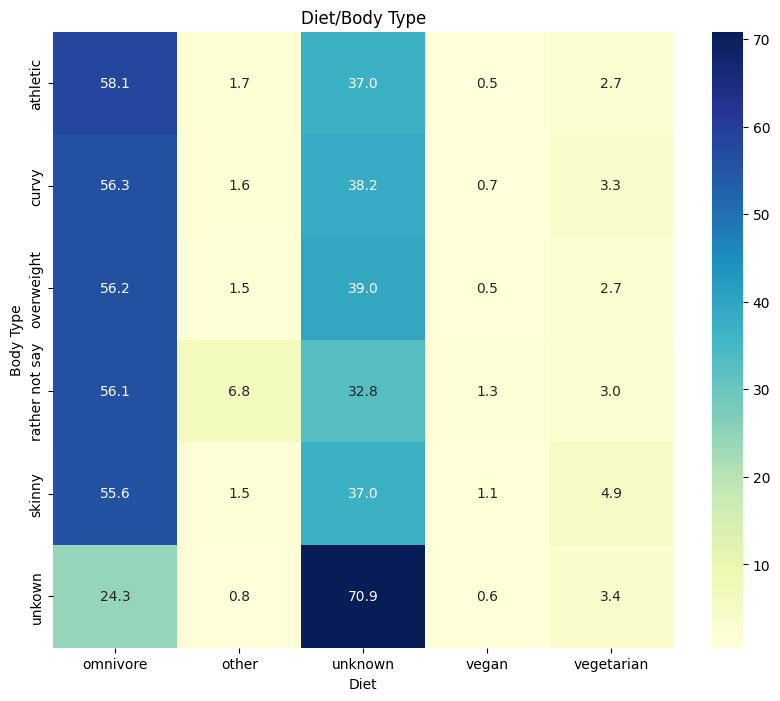

In [54]:
plt.figure(figsize=(10, 8))
sns.heatmap(bodytype_diet_percent, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Diet/Body Type")
plt.ylabel("Body Type")
plt.xlabel("Diet")
plt.show()

#### Income & Job

In [55]:
# Categorizing income into ranges
income_bins = [-1, 20000, 40000, 60000, 80000, 100000, 120000, 1000000]
income_labels = ['0-20k', '20k-40k', '40k-60k', '60k-80k', '80k-100k', '100k-120k', '120k+']
df_clean['income_range'] = pd.cut(df_clean['income'], bins=income_bins, labels=income_labels)

In [56]:
job_income_crosstab = pd.crosstab(df_clean['job'], df_clean['income_range'])

In [57]:
job_income_percent = job_income_crosstab.apply(lambda r: r/r.sum(), axis=1) * 100

job_income_percent

income_range,0-20k,20k-40k,40k-60k,60k-80k,80k-100k,120k+
job,,,,,,
Admin,82.345361,11.340206,3.994845,1.675258,0.128866,0.515464
Blue Collar,69.977255,9.097801,7.581501,8.263836,2.880970,2.198635
Creative,85.055351,4.312731,3.805351,2.629151,1.429889,2.767528
Education,83.352635,5.761436,5.993052,2.866242,0.839606,1.187030
Entertainment,83.680870,4.170444,3.309157,4.034451,2.765186,2.039891
Finance,84.686347,1.706642,2.998155,3.228782,3.551661,3.828413
Government,75.289017,4.479769,5.346821,8.670520,4.479769,1.734104
Healthcare,85.243593,3.520135,3.351169,3.294847,2.900591,1.689665
Legal,85.123967,2.554470,1.577761,4.207363,2.854996,3.681443


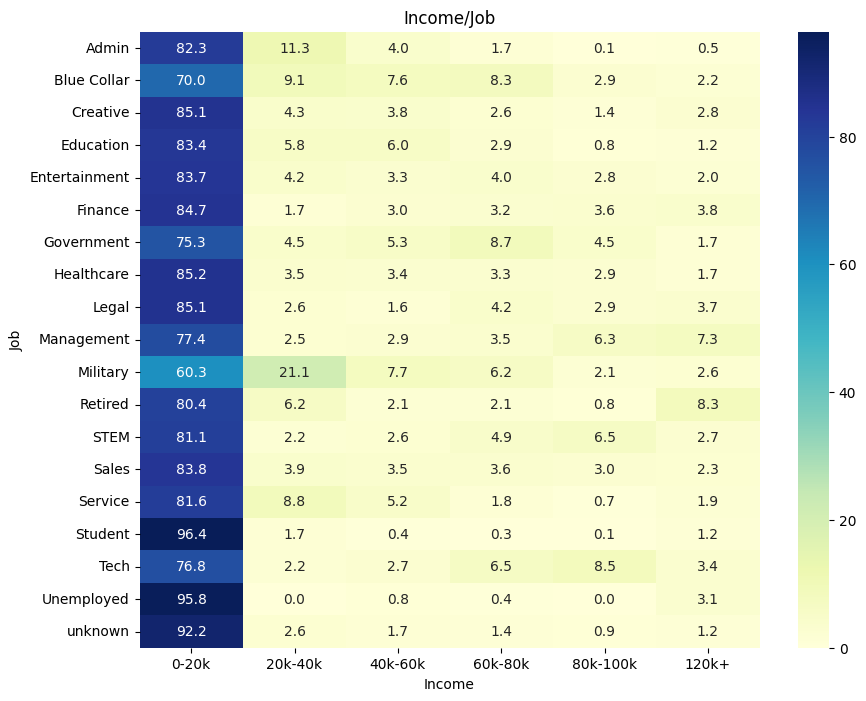

In [58]:
plt.figure(figsize=(10, 8))
sns.heatmap(job_income_percent, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Income/Job")
plt.ylabel("Job")
plt.xlabel("Income")
plt.show()

Interestingly, retired people have the highest proportion of income over 120k. It is also interesting to see that military personnel and blue collar workers have the lowest proportion of incomes below 20k.

#### Pet & Income

In [59]:
pet_income_crosstab = pd.crosstab(df_clean['pets'], df_clean['income_range'])

In [60]:
pet_income_percent = pet_income_crosstab.apply(lambda r: r/r.sum(), axis=1) * 100

pet_income_percent

income_range,0-20k,20k-40k,40k-60k,60k-80k,80k-100k,120k+
pets,,,,,,
dislikes cats,83.664881,4.361132,3.060444,3.442999,2.792655,2.677888
dislikes dogs,73.033708,7.022472,2.808989,7.022472,5.898876,4.213483
dislikes dogs & cats,81.283422,2.673797,4.278075,2.673797,2.139037,6.951872
likes cats,83.990046,4.479469,3.815844,3.732891,2.447117,1.534633
likes cats & dogs,83.990905,4.297624,3.339129,3.125139,2.817529,2.429673
likes dogs,85.879672,2.898815,2.844120,3.199635,2.771194,2.406563
unknown,88.483980,2.445364,2.105877,2.593889,2.498409,1.872480


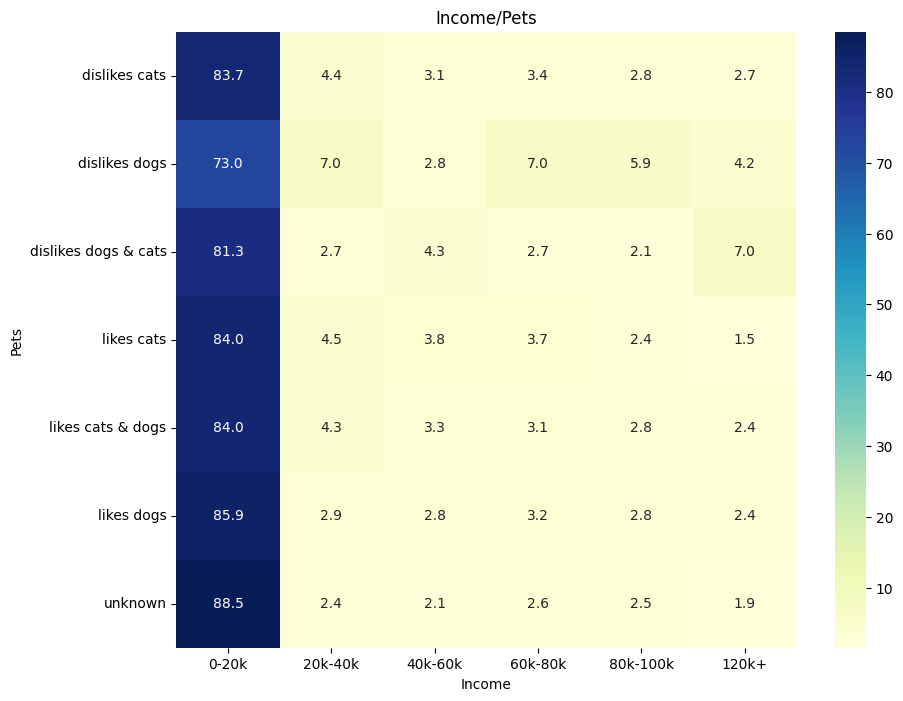

In [61]:
plt.figure(figsize=(10, 8))
sns.heatmap(pet_income_percent, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Income/Pets")
plt.ylabel("Pets")
plt.xlabel("Income")
plt.show()

Its peculiar to see that the highest concentration of high earners dislike cats and dogs. We will look into income further later.

#### Sex & Diet

In [62]:
sex_diet_crosstab = pd.crosstab(df_clean['sex'], df_clean['diet'])

In [63]:
sex_diet_percent = sex_diet_crosstab.apply(lambda r: r/r.sum(), axis=1) * 100
sex_diet_percent

diet,omnivore,other,unknown,vegan,vegetarian
sex,,,,,
f,52.365067,1.672226,40.890429,0.752716,4.319562
m,55.309388,1.594123,40.134731,0.528471,2.433288


Females are more likely to be vegetarian and vegan when compared to men

#### Orientation & Religion

In [64]:
orientation_religion_crosstab = pd.crosstab(df_clean['orientation'], df_clean['religion'])

In [65]:
orientation_religion_percent = orientation_religion_crosstab.apply(lambda r: r/r.sum(), axis=1) * 100
orientation_religion_percent

religion,agnosticism,atheism,buddhism,catholicism,christianity,hinduism,islam,judaism,other,unknown
orientation,,,,,,,,,,
bisexual,16.309963,18.671587,4.760148,2.730627,4.944649,0.295203,0.184502,4.723247,22.656827,24.723247
gay,14.227567,12.007401,4.995375,7.400555,7.104533,0.481036,0.166512,4.218316,14.967623,34.431082
straight,14.919728,11.429204,3.019756,8.204241,10.117491,0.806744,0.231360,5.375609,12.314409,33.581459


Interestingly, people who identify as bisexual are most likely to report their beliefs and have the highest proportion of individuals classified as agnostic and aetheist

#### Age & Diet

In [66]:
age_bins = [17, 24, 34, 44, 54, 64, 70]
age_labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']
df_clean['age_group'] = pd.cut(df_clean['age'], bins=age_bins, labels=age_labels)

In [67]:
age_diet = pd.crosstab(df_clean['age_group'], df_clean['diet'])

In [68]:
age_diet_percent = pd.crosstab(df_clean['age_group'], df_clean['diet']).apply(lambda r: r/r.sum(), axis=1) * 100
age_diet_percent

diet,omnivore,other,unknown,vegan,vegetarian
age_group,,,,,
18-24,58.973142,2.002467,34.326658,0.797191,3.900541
25-34,54.097803,1.537101,40.369312,0.666531,3.329253
35-44,51.481255,1.450669,43.817181,0.480643,2.770253
45-54,49.915805,1.780130,45.681982,0.384893,2.237190
55-64,52.212389,1.665799,43.675169,0.312337,2.134305
65+,56.302521,1.400560,40.056022,0.280112,1.960784


Younger people report their dietary preferences more frequently. This might indicate that allignment of dietary preferences is more important for younger age groups.

#### Age & Drinks

In [69]:
age_drinks = pd.crosstab(df_clean['age_group'], df_clean['drinks'])

In [70]:
age_drinks_percent = pd.crosstab(df_clean['age_group'], df_clean['drinks']).apply(lambda r: r/r.sum(), axis=1) * 100
age_drinks_percent

drinks,0,1,2,3,4,5,6
age_group,,,,,,,
18-24,5.751163,5.988422,9.642213,67.381608,9.215147,1.262219,0.759229
25-34,4.798340,3.699925,8.311229,72.029518,9.783718,0.799157,0.578113
35-44,4.220921,6.239622,11.255790,69.990387,7.393166,0.533077,0.367037
45-54,3.752706,10.416166,14.529709,65.720471,5.003608,0.288670,0.288670
55-64,2.967205,11.972931,17.803227,62.571577,4.216554,0.156169,0.312337
65+,2.521008,14.005602,18.207283,62.184874,2.801120,0.000000,0.280112


Most people report their drinking habits. 0 is mapped to unknown. Take note that more people 18-24 do not drink at all as compared to 25-34, but more people in 18-24 drink very often or desperately.

#### Age & Drugs

In [71]:
age_drugs = pd.crosstab(df_clean['age_group'], df_clean['drugs'])

In [72]:
age_drugs_percent = pd.crosstab(df_clean['age_group'], df_clean['drugs']).apply(lambda r: r/r.sum(), axis=1) * 100
age_drugs_percent

drugs,0,1,2,3
age_group,,,,
18-24,21.638037,57.388251,19.085129,1.888583
25-34,25.736244,60.378834,13.334013,0.550908
35-44,25.290571,64.755746,9.682775,0.270908
45-54,17.320183,75.126293,7.481357,0.072167
55-64,12.493493,80.426861,6.923477,0.156169
65+,10.644258,82.352941,6.722689,0.280112


Unsurprisingly, people between the ages of 18 and 34 do the most drugs by far.

#### Age & Income

In [73]:
age_income = pd.crosstab(df_clean['age_group'], df_clean['income_range'])

In [74]:
age_income_percent = pd.crosstab(df_clean['age_group'], df_clean['income_range']).apply(lambda r: r/r.sum(), axis=1) * 100
age_income_percent

income_range,0-20k,20k-40k,40k-60k,60k-80k,80k-100k,120k+
age_group,,,,,,
18-24,91.942678,3.274177,1.357123,1.252728,0.521970,1.651324
25-34,85.890635,3.880161,2.921173,2.829355,2.407672,2.071006
35-44,82.076379,2.953771,3.478109,3.950013,4.500568,3.041161
45-54,81.477027,2.285302,3.800818,5.003608,4.738994,2.694251
55-64,81.259761,2.915148,3.643935,5.674128,4.112441,2.394586
65+,78.711485,5.602241,5.602241,5.042017,2.801120,2.240896


# Finding 1: Income Coefficient Investigation

#### Lasso Regression

In [75]:
income_regression = pd.get_dummies(data = df_clean, columns = ['status','sex',\
            'orientation','body_type','diet','education', 'ethnicity', 'job',\
            'offspring', 'pets', 'religion'], dtype = int)

In [76]:
income_regression = income_regression.drop(columns =['essay0', 'essay1', 'essay2','essay3','essay4',\
                            'essay5','essay6','essay7','essay8','essay9',\
                            'location','speaks', 'height', "age_group"], axis=1)

In [77]:
sign_order = {
    'capricorn': 1, 'aquarius': 2, 'pisces': 3, 'aries': 4, 
    'taurus': 5, 'gemini': 6, 'cancer': 7, 'leo': 8, 
    'virgo': 9, 'libra': 10, 'scorpio': 11, 'sagittarius': 12,
    'unknown': 0
}

income_regression['sign'] = income_regression['sign'].map(sign_order)

In [78]:
Y = income_regression.income

In [79]:
X = income_regression.drop(['income', 'income_range'], axis=1)

In [80]:
regLasso_income = linear_model.Lasso()
regLasso_income.fit(X,Y)

Lasso()

#### Coefficient List

In [81]:
coef_data = {X.columns[i]: regLasso_income.coef_[i] for i in range(0,len(X.columns))}

In [82]:
coef_series = pd.Series(coef_data)
coef_series[coef_series != 0].sort_values(ascending=False).head(50)

job_Retired                  6.128252e+04
body_type_rather not say     4.113354e+04
diet_other                   3.050008e+04
pets_dislikes dogs & cats    2.171635e+04
offspring_Wants More Kids    1.657505e+04
ethnicity_Other              1.370341e+04
pets_dislikes dogs           1.163841e+04
job_Military                 1.124883e+04
job_Management               9.770505e+03
education_unknown            7.924003e+03
ethnicity_Middle Eastern     7.820450e+03
job_Government               7.414004e+03
religion_buddhism            6.815080e+03
drugs                        6.433988e+03
job_Creative                 6.212933e+03
diet_vegan                   5.761535e+03
ethnicity_Mixed              5.702802e+03
religion_other               4.723492e+03
orientation_bisexual         3.834805e+03
education_High School        3.811724e+03
religion_hinduism            3.584925e+03
body_type_athletic           3.361401e+03
job_Unemployed               3.295348e+03
drinks                       3.258

Based on the coefficients provided by Lasso we chose to look into Job type, Pet preference, and kid preferences, and drugs and drinking habits. We chose to avoid looking into protected attributes involving ethnicity like religion and diet. We avoided drawing conclusions with these features so that our recommendations would be ethical and actionable.

#### Decision Tree Regressor

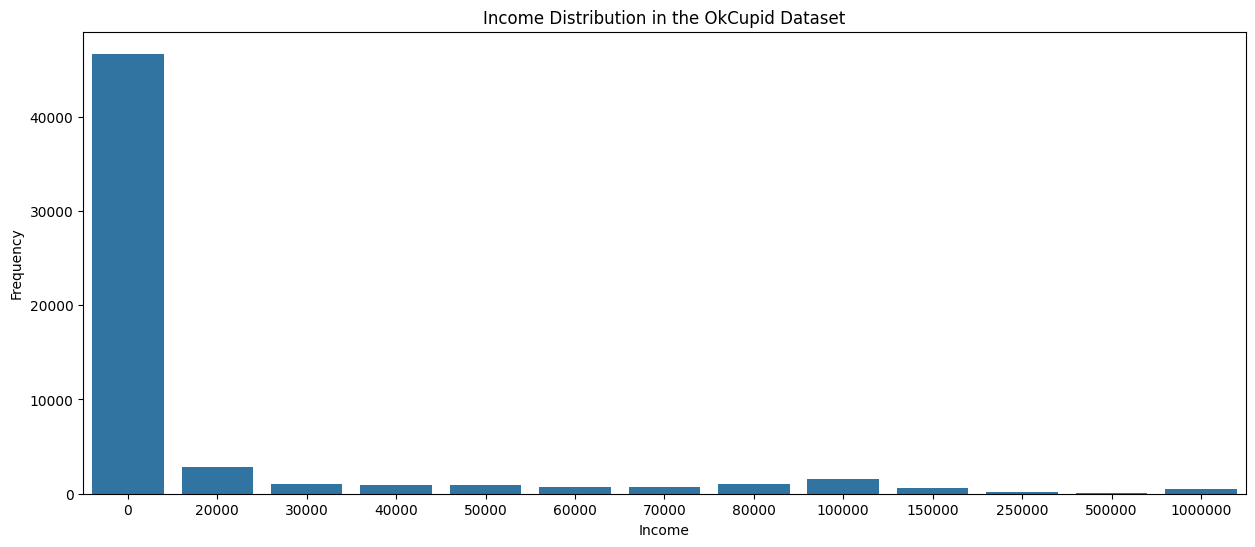

In [83]:
income_counts = df_clean['income'].value_counts().sort_index()

# Creating the plot for 'income'
plt.figure(figsize=(15, 6))
sns.barplot(x=income_counts.index, y=income_counts.values)
plt.title('Income Distribution in the OkCupid Dataset')
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.show()

In [84]:
dt_income = sklearn.tree.DecisionTreeRegressor(max_depth=2)
dt_income.fit(X,Y)

DecisionTreeRegressor(max_depth=2)

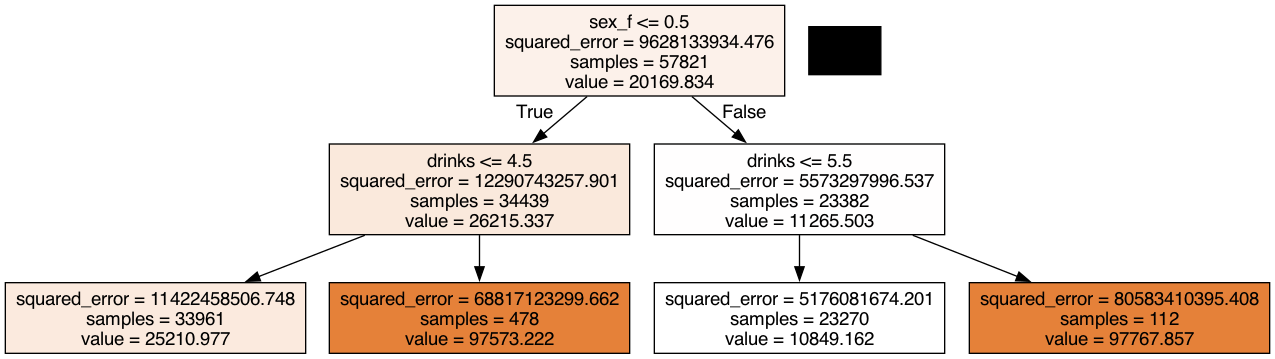

In [85]:
dt_feature_names = list(X.columns)
dt_target_names = np.array(Y.unique(),dtype=np.int_) 
tree.export_graphviz(dt_income, out_file='tree.dot',
    feature_names=dt_feature_names, class_names=dt_target_names,
    filled=True)  
graph = pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())

The squared error scores are unusually high. We believe that this may be because the income values are imbalance. Over 80% of individuals list their income as 0. In light of this, we can see that the decision tree regressor chooses sex and drink frequency as the main determinants of income level which corresponds to the coefficient weights found in lasso. This reinforces our decision to look into lifestyle choices like drinking and drug habits.

### Coefficient Investigation

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


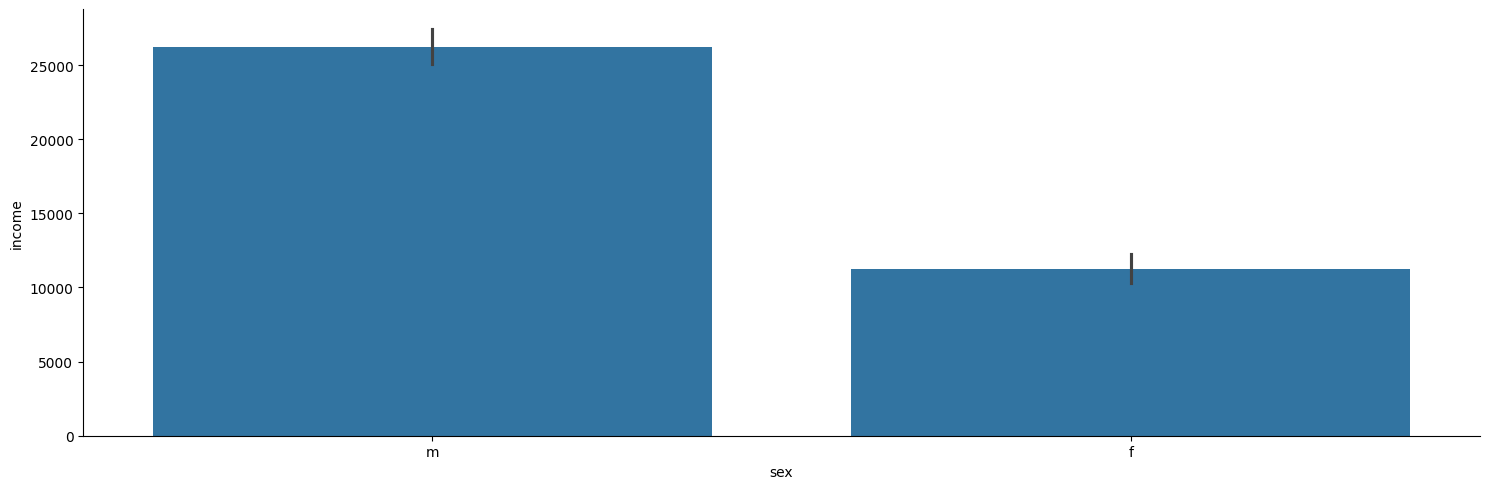

In [86]:
sns.catplot(y='income', x='sex', data=df_clean, kind='bar', aspect=3)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


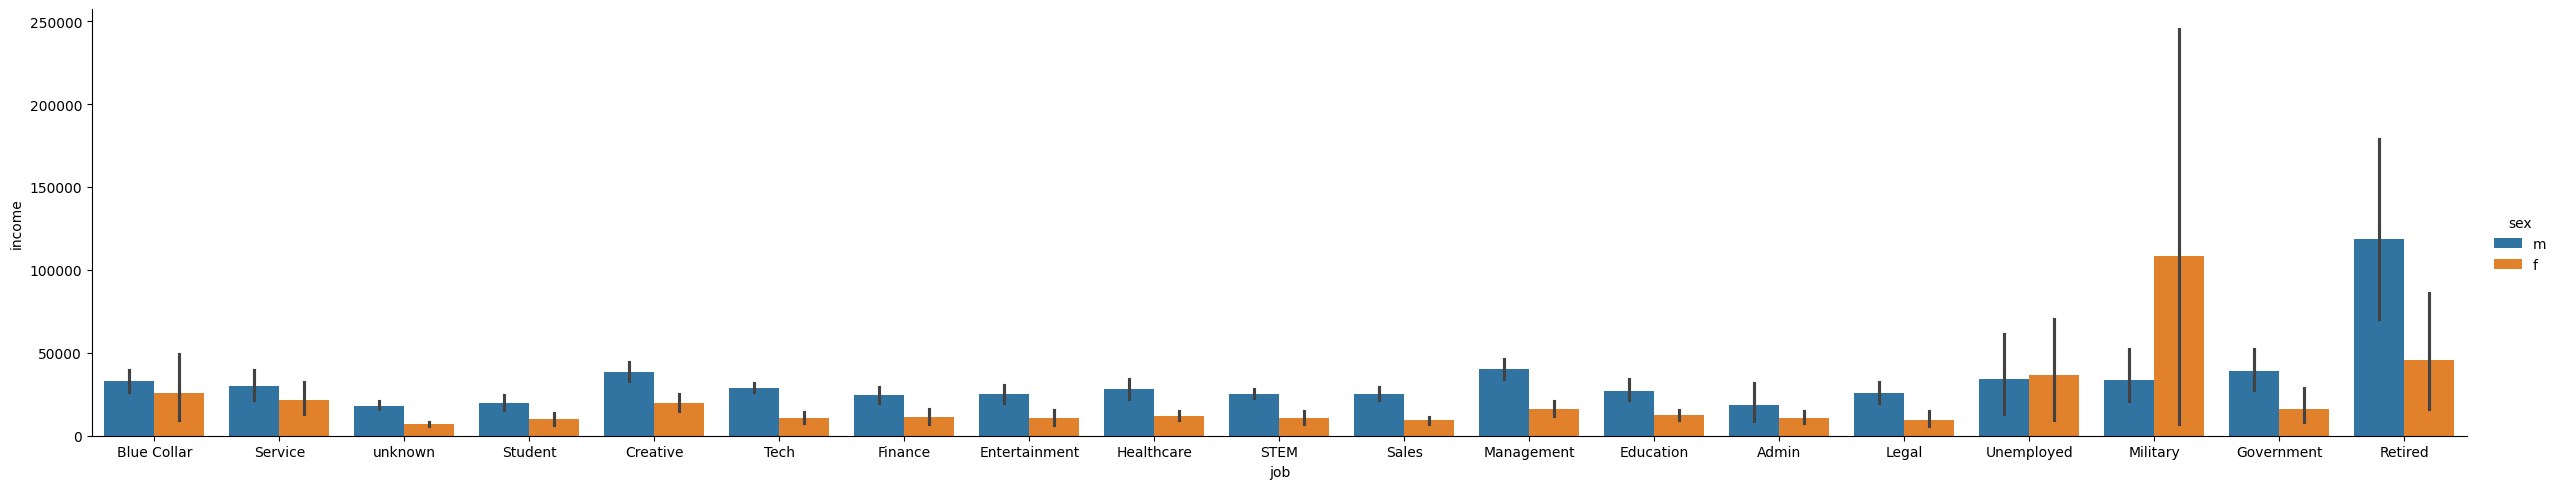

In [87]:
sns.catplot(y='income', x='job', hue= 'sex',data=df_clean, kind='bar', aspect=5)

We see that retired individuals make the most out of all job types. This is slightly idiosyncratic because we would expect people currently in the workforce to have higher incomes than those who do not work. We also see that women in the military make much more money on average than women in any of the other job types.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


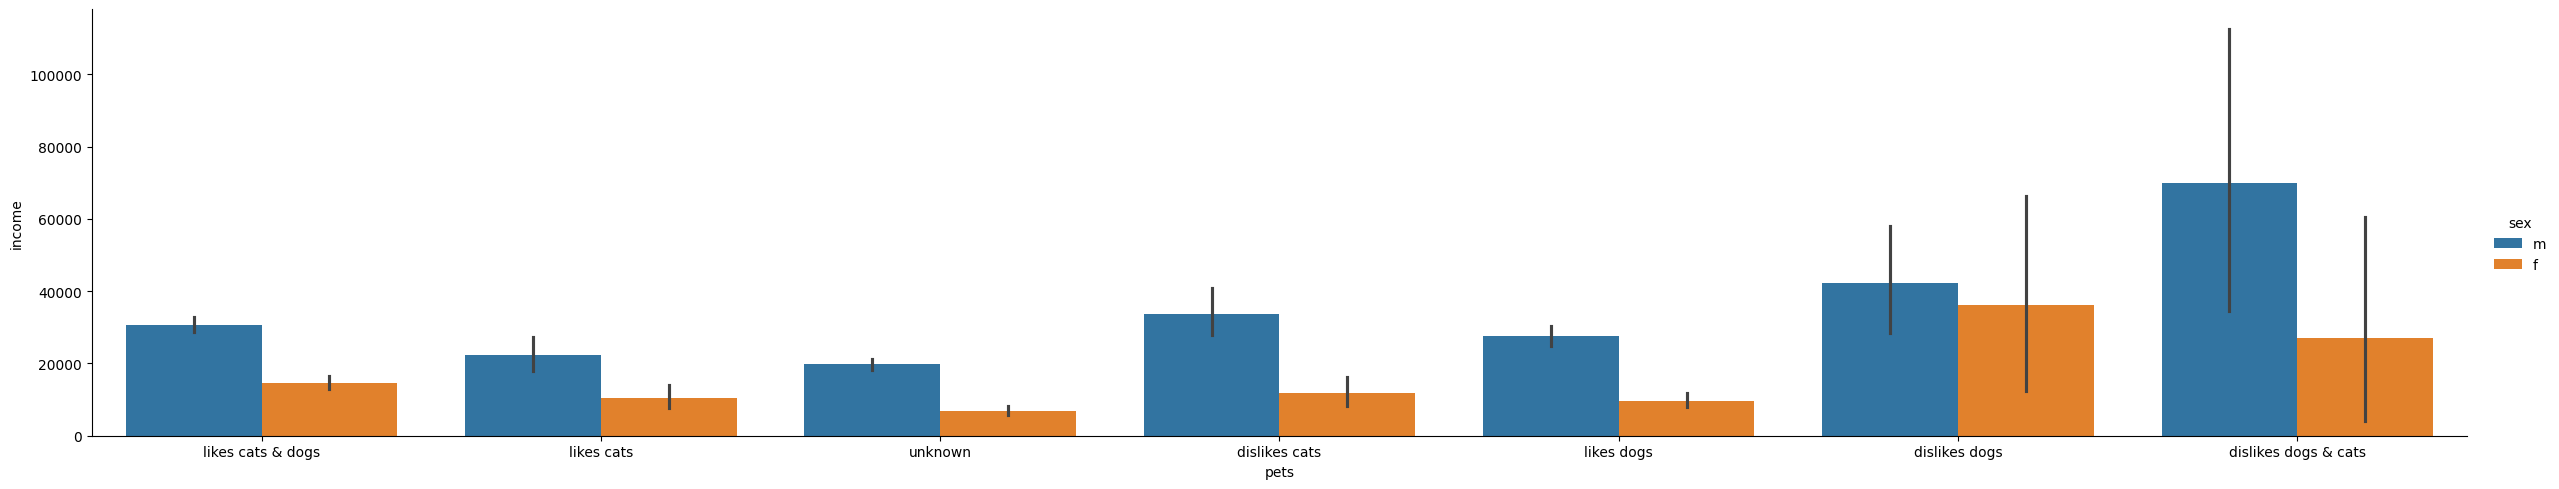

In [88]:
sns.catplot(y='income', x='pets', hue='sex', data=df_clean, kind='bar', aspect=5)

Interestingly, we see that people who claim to dislike dogs make much more money than those who like dogs. One possible explanation is that high earners don’t have time to care for high maintenance animals like dogs. The explanation could be more psychological, commenting on a potential lack of empathy in the highest earners in the workforce.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


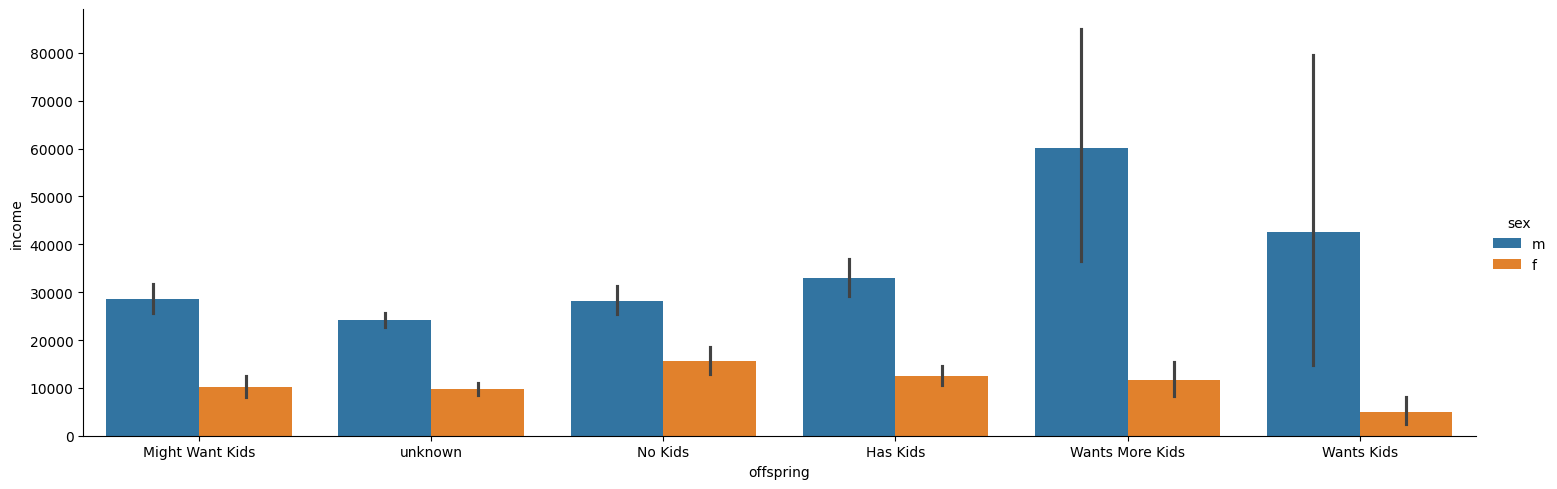

In [89]:
sns.catplot(y='income', x='offspring', hue='sex', data=df_clean, kind='bar', aspect=3)

The trend between income and kid preferences on the other hand makes more sense. People who want kids make more money. It makes sense that people who can justify having kids would have the resources to support a child.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


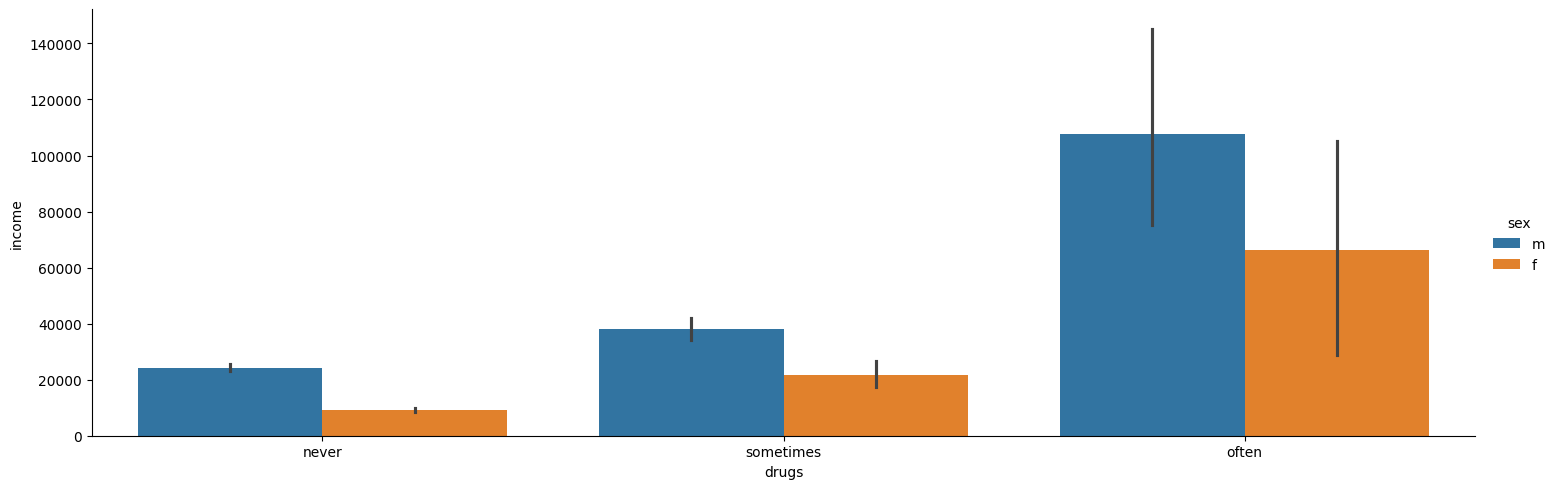

In [90]:
sns.catplot(y='income', x='drugs', hue='sex', data=df, kind='bar', aspect=3)

We see a clear positive relationship between drug use and income. This relationship is more stark compared to drinking. Level 1 means no drugs, level 2 is some, and level 3 is frequent drug use. We see an immediate jump in income from level 1 to level 2, and an exponential jump in income between levels 2 and 3

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


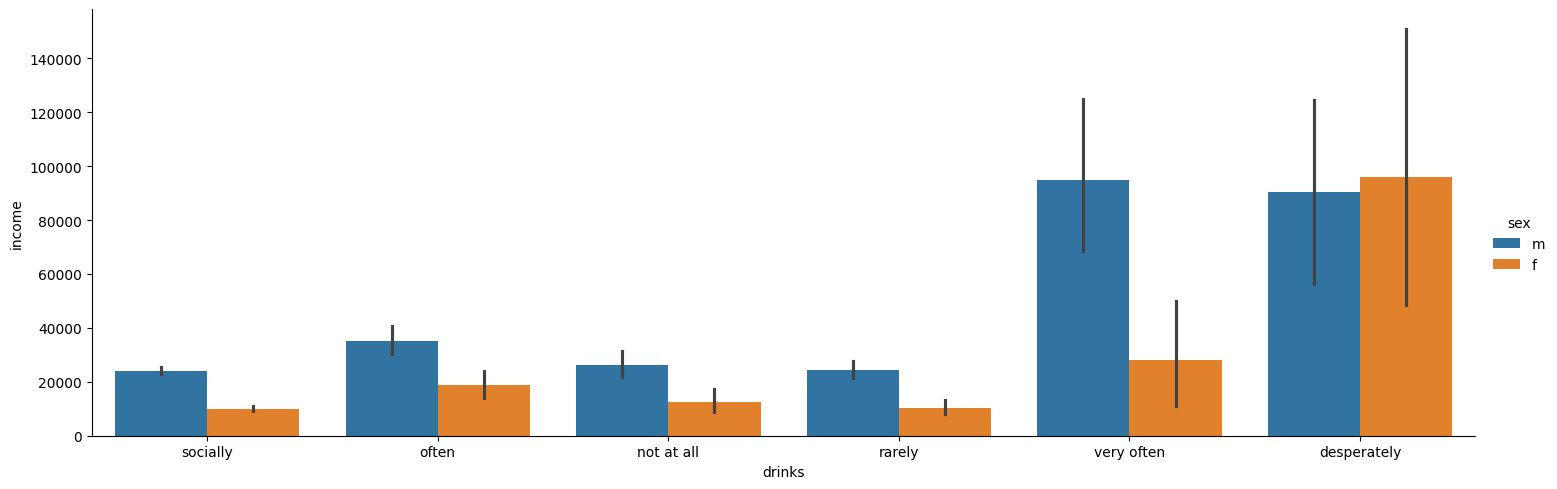

In [91]:
sns.catplot(y='income', x='drinks', hue='sex', data=df, kind='bar', aspect=3)

As reinforced by the decision tree, drinking has a strongly positive relationship with income after level 4. We see that men who drink frequently and desperately have the same high income distribution. In contrast, women have roughly the same level of income between levels 1 and 5, but average income dramatically increases for women who drink at the highest frequency. Here we can confidently say that men who drink at the top two highest levels on average earn the highest salaries. Women who drink at the highest level earn the highest salaries.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


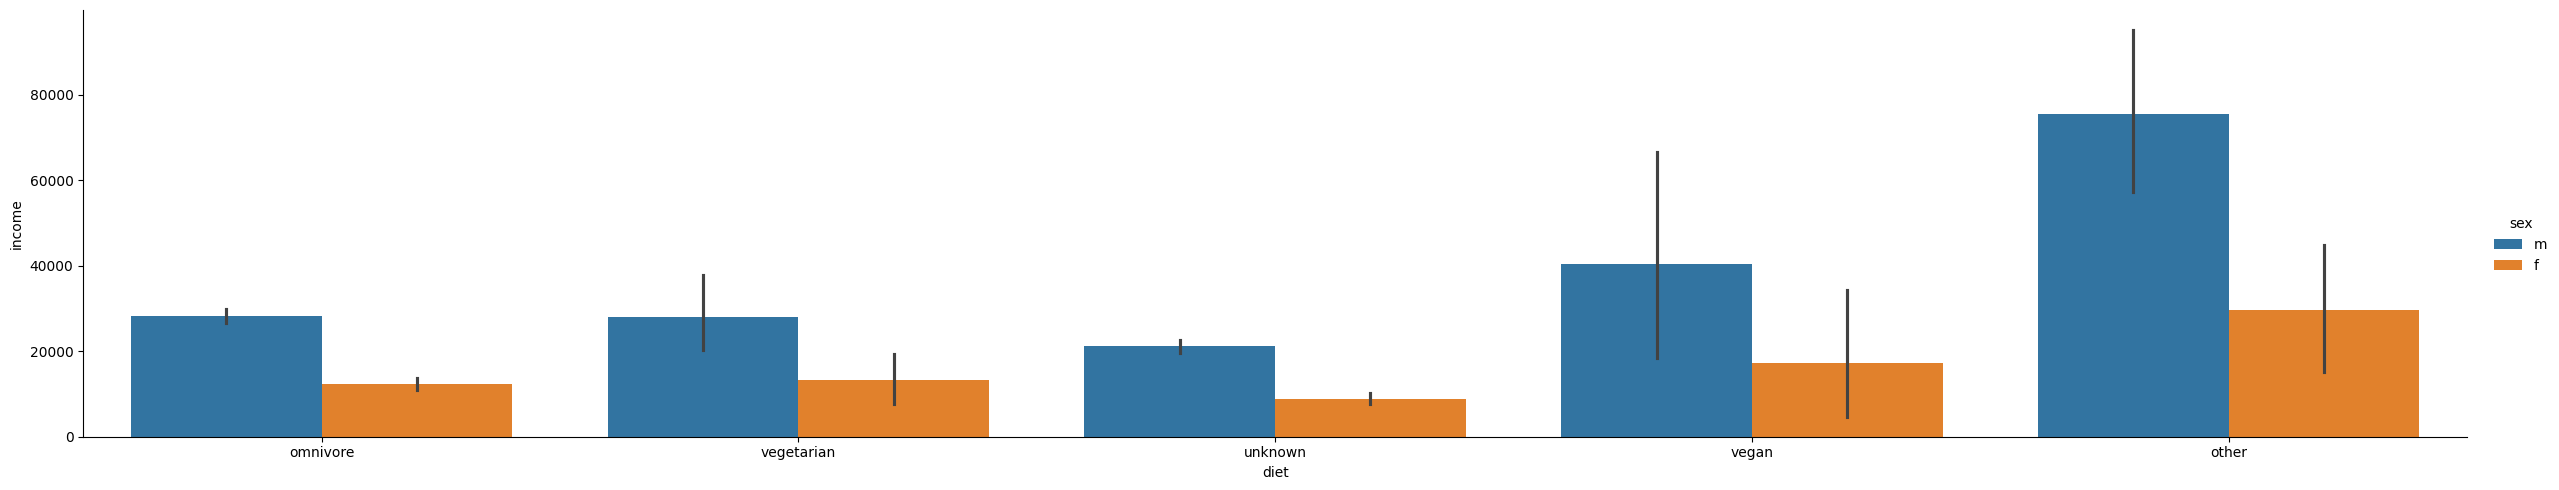

In [92]:
sns.catplot(y='income', x='diet', hue='sex', data=df_clean, kind='bar', aspect=5)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


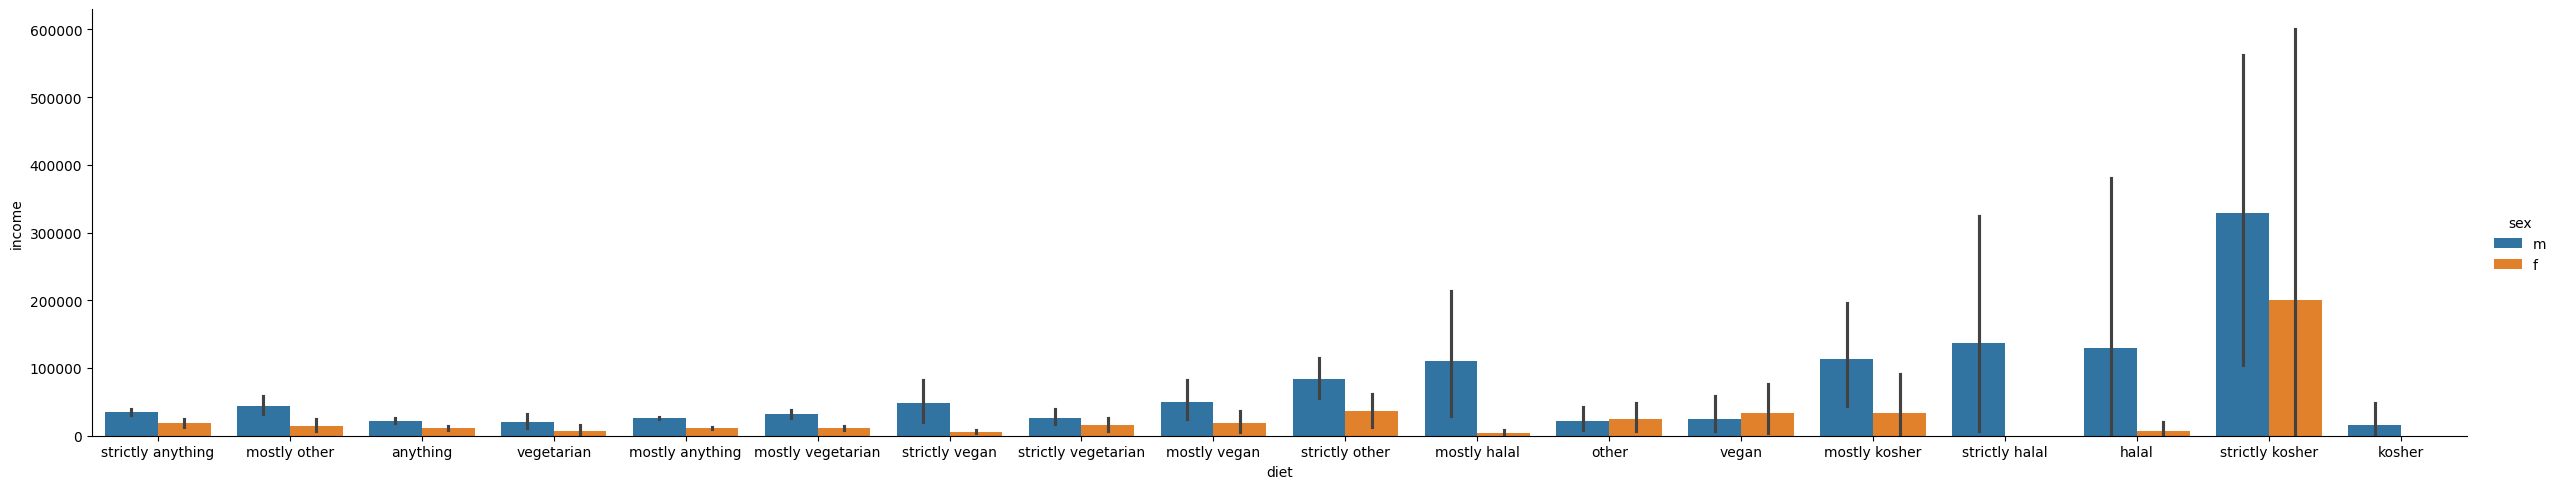

In [93]:
sns.catplot(y='income', x='diet', hue='sex', data=df, kind='bar', aspect=5)

Here is an example validating our choice not to include ethnic features in our analysis.

## Finding 1 Conclusions

Correlated Features:

- Jobs: retired, women in the military
- Pets: individuals who dislike dogs
- Kids: individuals who want kids
- Drinks: men at the top two frequencies, women at the highest frequency
- Drugs: individuals who do more drugs


The distinct relationships that we discovered in the jobs, pets, kids, drinks and drug responses could help OkCupid sales teams to accurately predict income levels in the absences of explicit income information. In doing so, the sales team could target individuals whose responses meet the above criteria and presumably increase volume of premium subscription purchases. This information could also help sharpen the OkCupid match making algorithm, to match people at the highest income level regardless of the presence of explicit income information. 

# Finding 2: Sentiment Ratio Coefficient Investigation

#### Creating sentiment_ratio for combined essay text

In [94]:
# Combine essay columns
df_clean['combined_essays'] = df_clean[['essay0', 'essay1', 'essay2', 'essay3', 'essay4', 'essay5', 'essay6', 'essay7', 'essay8', 'essay9']].fillna('').agg(' '.join, axis=1)

In [95]:
# Function to clean text
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    # Remove special characters
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)
    return text

In [96]:
positive_words = set(opinion_lexicon.positive())
negative_words = set(opinion_lexicon.negative())

In [97]:
# Function to calculate sentiment ratio: positive count/negative count
def calculate_ratio(text):
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(word) for word in tokens]
    pos_count = sum(1 for word in lemmatized if word.lower() in positive_words)
    neg_count = sum(1 for word in lemmatized if word.lower() in negative_words)
    
    # Avoid division by zero
    if neg_count == 0:
        if pos_count > 0:
            return pos_count
        else:
            return 1
    return pos_count / neg_count

In [98]:
# Apply the cleaning function to the combined essays
df_clean['combined_essays'] = df_clean['combined_essays'].apply(clean_text)

# Apply the function to calculate the ratio
df_clean['sentiment_ratio'] = df_clean['combined_essays'].apply(calculate_ratio)

In [99]:
df_clean_sa = df_clean.copy()

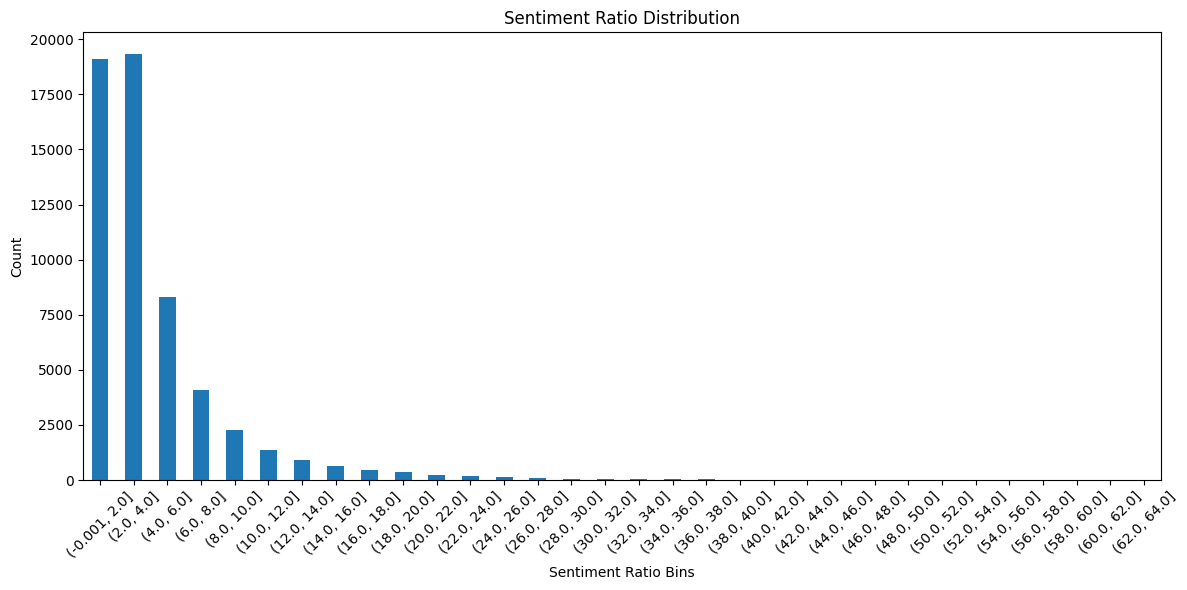

In [100]:
# Define bins from 0 to 66, every 2 units
bins = list(range(0, 66, 2))  

# Categorize the sentiment ratios into bins
# Set 'right' to True to include the rightmost edge of the bins
df_clean_sa['ratio_bins'] = pd.cut(df_clean_sa['sentiment_ratio'], bins=bins, right=True, include_lowest=True)

# Count the values in each bin
bin_counts = df_clean_sa['ratio_bins'].value_counts().sort_index()  # Sorting for orderly bars

# Plot a bar chart
plt.figure(figsize=(12, 6))
bin_counts.plot(kind='bar')
plt.title('Sentiment Ratio Distribution')
plt.xlabel('Sentiment Ratio Bins')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Describe the column we created. It contains the ratio of positive words to negative words in all of the written response columns per row. Most individuals have a sentiment ratio between 1 and 4, indicating that people are generally positive. So what we decided to explore was what features contribute to the relative positivity between individuals.

#### Lasso Regression Y = sentiment_ratio

In [101]:
sentiment_regression = pd.get_dummies(data=df_clean,columns=['status','sex',\
            'orientation','body_type','diet','education', 'ethnicity', 'height',\
            'job', 'offspring', 'pets', 'religion'], dtype = int)

In [102]:
sentiment_regression = sentiment_regression.drop(columns =['essay0', 'essay1', 'essay2','essay3',\
                            'essay4','essay5','essay6','essay7','essay8','essay9',\
                            'combined_essays', 'location','speaks', 'age_group', 'income_range'], axis=1)

In [103]:
sign_order = {
    'capricorn': 1, 'aquarius': 2, 'pisces': 3, 'aries': 4, 
    'taurus': 5, 'gemini': 6, 'cancer': 7, 'leo': 8, 
    'virgo': 9, 'libra': 10, 'scorpio': 11, 'sagittarius': 12,
    'unknown': 0
}

sentiment_regression['sign'] = sentiment_regression['sign'].map(sign_order)

In [104]:
Y = sentiment_regression.sentiment_ratio

In [105]:
X = sentiment_regression.drop('sentiment_ratio', axis=1)

In [106]:
regLasso_sentiment = linear_model.Lasso()
regLasso_sentiment.fit(X,Y)

Lasso()

#### Coefficient List

In [107]:
coef_data = {X.columns[i]: regLasso_sentiment.coef_[i] for i in range(0,len(X.columns))}

In [108]:
coef_series = pd.Series(coef_data)
coef_series[coef_series != 0].sort_values(ascending=False).head(50)

age       0.114398
income   -0.000001
dtype: float64

Using lasso, we found that age has the highest coefficient when predicting the sentiment ratio, and that income has some relationship with the prediction of income.

#### Decision Tree

In [109]:
dt_sentiment = sklearn.tree.DecisionTreeRegressor(max_depth=3)

In [110]:
dt_sentiment.fit(X,Y)

DecisionTreeRegressor(max_depth=3)

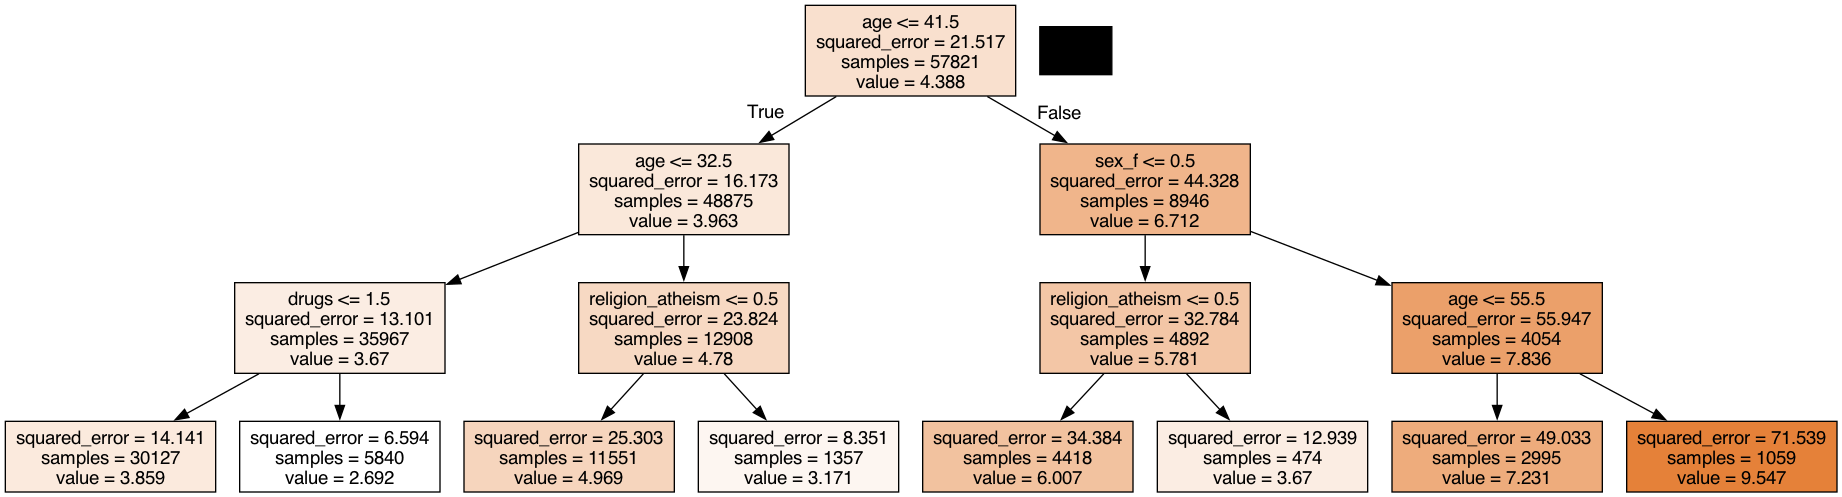

In [111]:
dt_feature_names = list(X.columns)
dt_target_names = np.array(Y.unique(),dtype=np.string_) 
tree.export_graphviz(dt_sentiment, out_file='tree.dot',
    feature_names=dt_feature_names, class_names=dt_target_names,
    filled=True)  
graph = pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())

### Coefficient Investigation

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


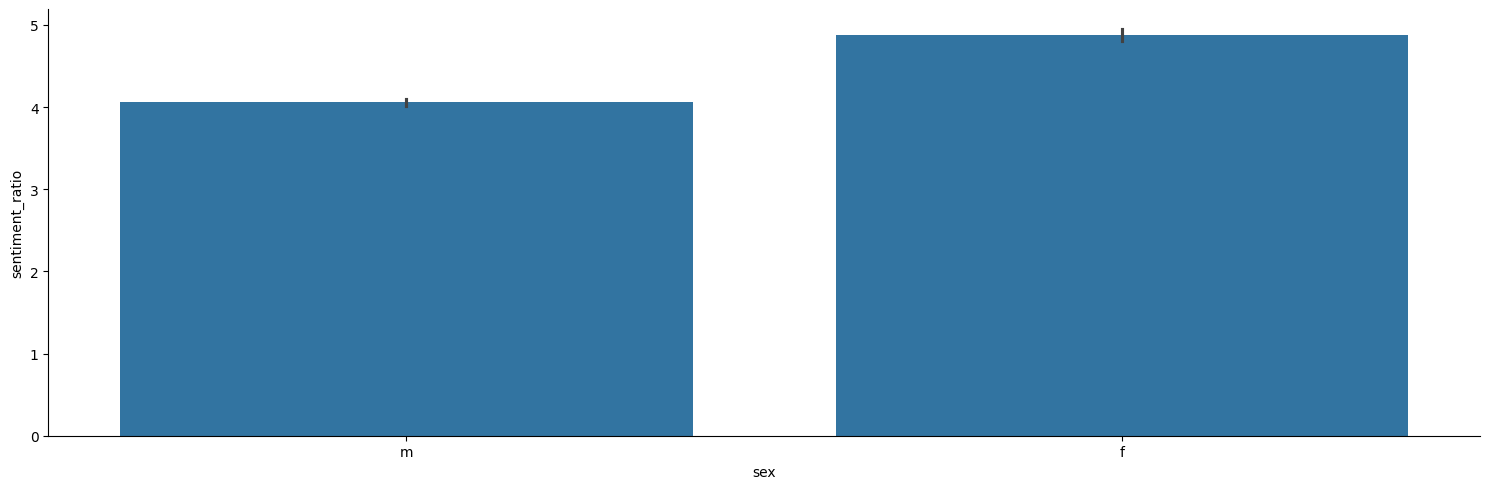

In [112]:
sns.catplot(y='sentiment_ratio', x='sex', data=df_clean, kind='bar', aspect=3)

Demographically, females are on average more positive than males.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


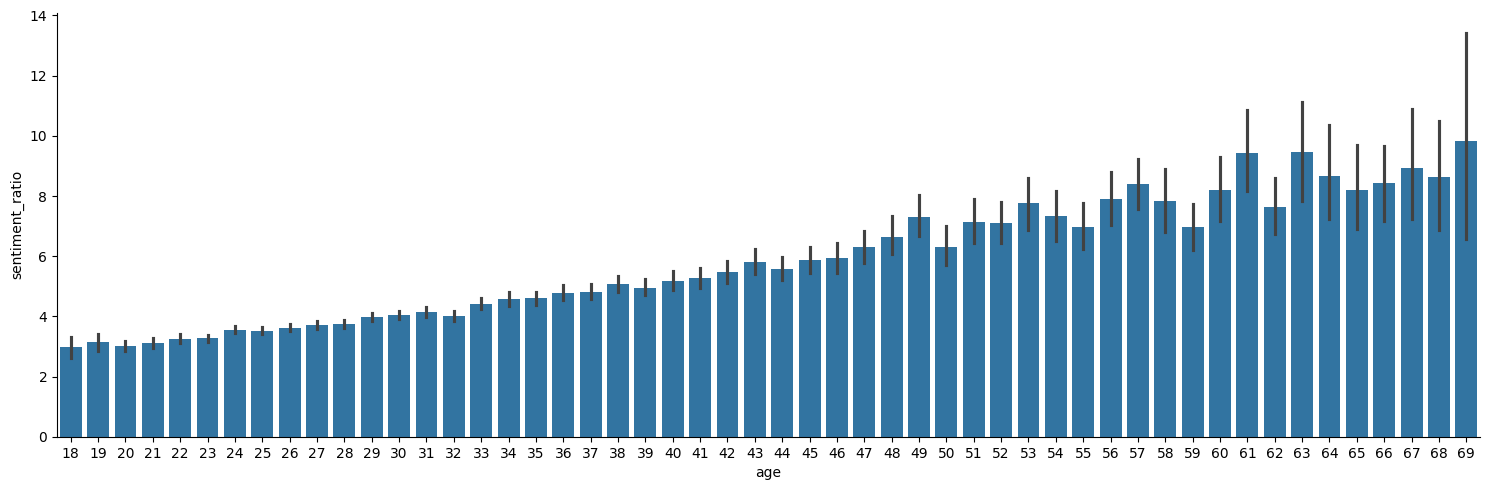

In [113]:
sns.catplot(y='sentiment_ratio', x='age', data=df_clean, kind='bar', aspect=3)

There is a clearly linear relationship between age and sentiment ratio. There might be some interesting sociological commentary for why this relationship exists. Perhaps it is cooler to be more negative when you are young (edgey). As individuals get older, positivity might be more attractive.

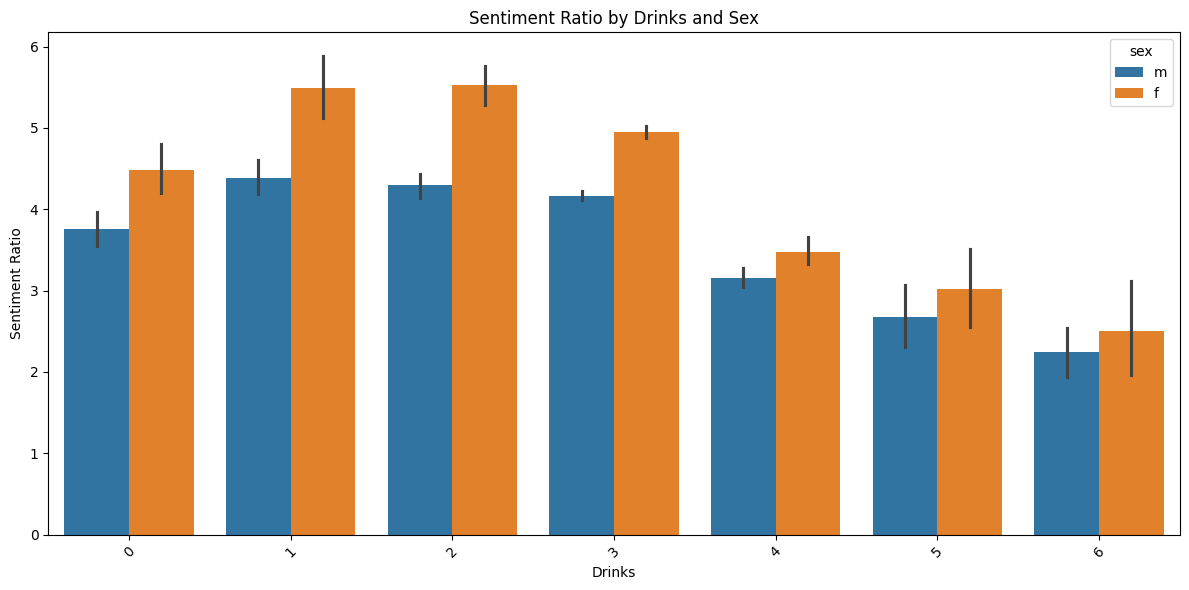

In [114]:
plt.figure(figsize=(12, 6))
sns.barplot(x='drinks', y='sentiment_ratio', hue='sex', data=df_clean)

plt.title('Sentiment Ratio by Drinks and Sex')
plt.xlabel('Drinks')
plt.ylabel('Sentiment Ratio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

0 is NaN values, 1 is never. After 1, drink frequency increases incrementally. The more people drink, the less positive their essay responses are.

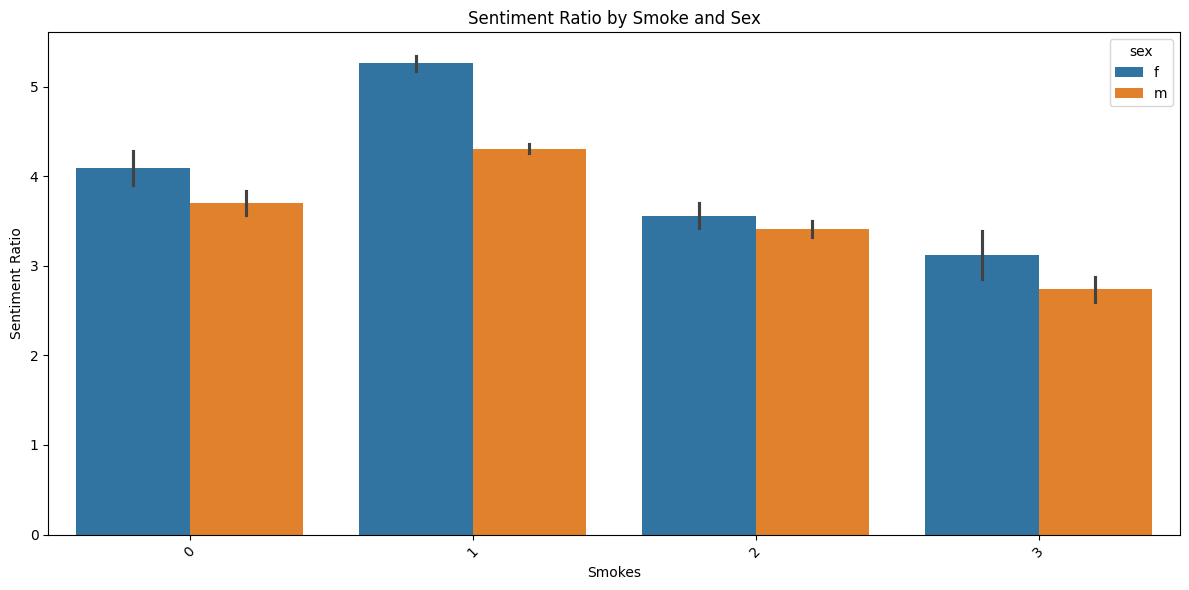

In [115]:
plt.figure(figsize=(12, 6))
sns.barplot(x='smokes', y='sentiment_ratio', hue='sex', data=df_clean)

plt.title('Sentiment Ratio by Smoke and Sex')
plt.xlabel('Smokes')
plt.ylabel('Sentiment Ratio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

0 is NaN values, 1 is never. After 1, smoking frequency increases incrementally. Interestingly, the more frequently people smoke, the less positive their essay responses are. This might relate to the reasons that individuals smoke to begin with.

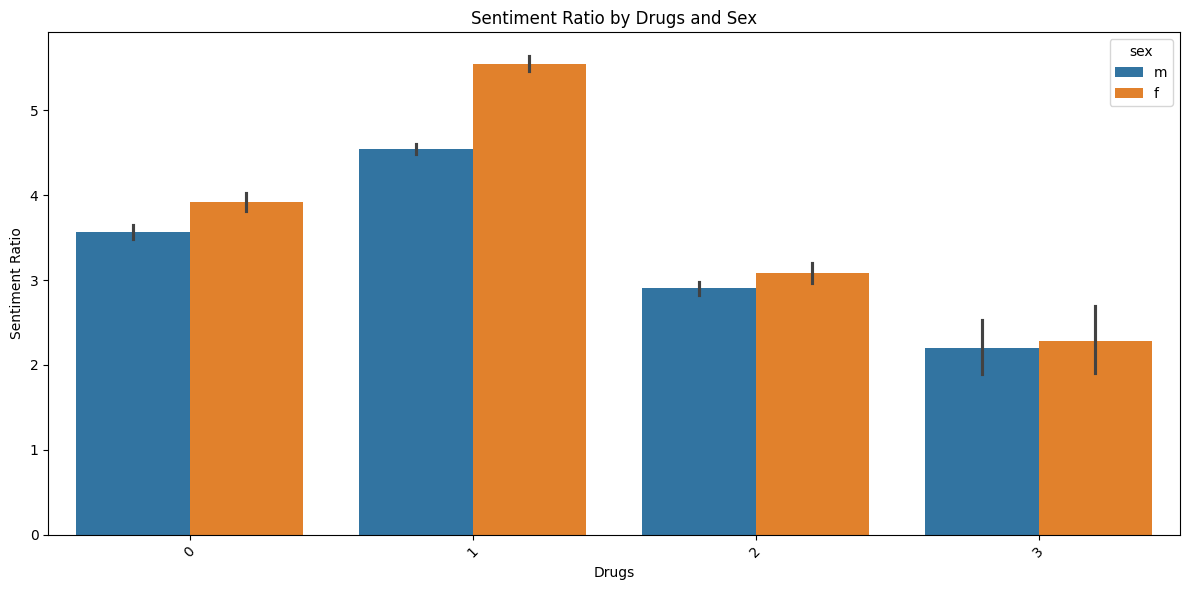

In [116]:
plt.figure(figsize=(12, 6))
sns.barplot(x='drugs', y='sentiment_ratio', hue='sex', data=df_clean)

plt.title('Sentiment Ratio by Drugs and Sex')
plt.xlabel('Drugs')
plt.ylabel('Sentiment Ratio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

0 is NaN values, 1 is never. After 1, drug frequency increases incrementally. The same relationship exists here.

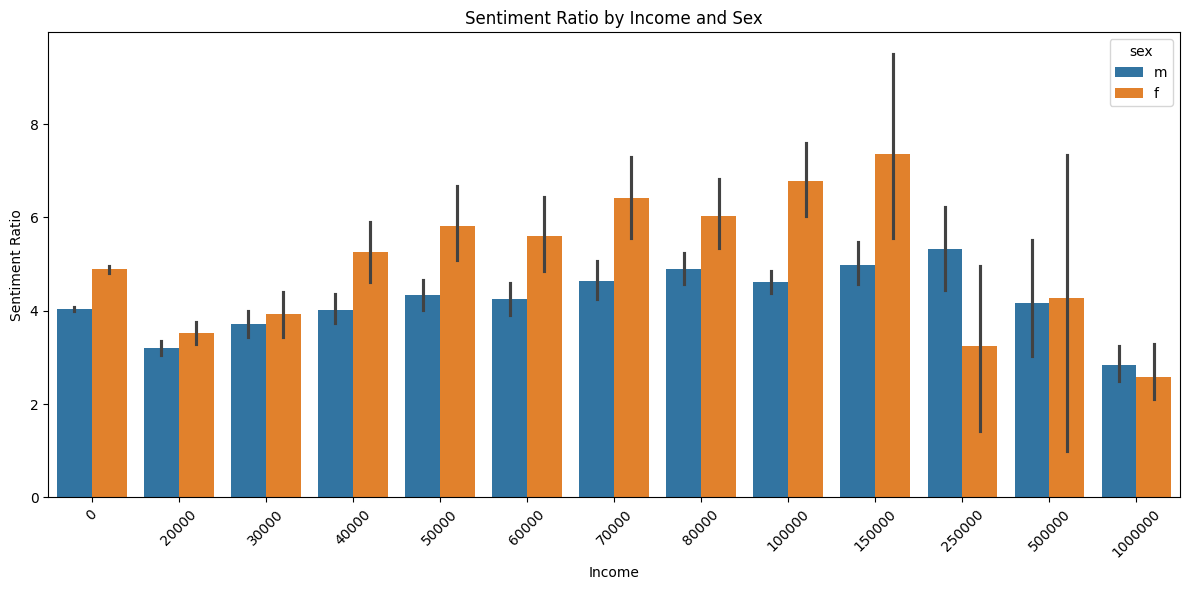

In [117]:
plt.figure(figsize=(12, 6))
sns.barplot(x='income', y='sentiment_ratio', hue='sex', data=df_clean)

plt.title('Sentiment Ratio by Income and Sex')
plt.xlabel('Income')
plt.ylabel('Sentiment Ratio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Lastly, Lasso regression showed that income has the highest coefficient as it relates to the prediction of sentiment ratio. As we can see, people become much more positive between income of 20000 and 150000. After 150000, positivity drops off. This might comment on the age-old adage that money cannot buy happiness after a certain point. We also see that this positive relationship is more dramatic for females as compared to males, however this might be because females are generally more positive than males.

## Finding 2 Conclusions

Correlated Features:
- Age
- Drinks
- Smokes
- Drugs
- Income

These five columns show us distinct relationships with the sentiment of individuals’ essay responses. These written responses require the most time and effort to fill out, so people are less likely to complete them when making their dating profiles. This is reflected in the amount of NaNs in these columns. We presume that matching positivity level is important to making a good match. Our proposal is that OkCupid uses the information in these four columns to create a sentiment score, in the absence of essay responses. As a result, the OkCupid algorithm could make help create more fitting matches on the basis of sentiment ratio between individuals who do not fill out essay responses.

# Finding 3: Profile Completeness

In [118]:
def calculate_profile_completeness(row):
    incomplete_values = ((row == 'unknown') | (row == 0) | (row== 'No response')).sum()
    total_values = len(row) - incomplete_values
    completeness_percentage = round((total_values / len(row)) * 100)
    return completeness_percentage

In [119]:
df_clean['profile_completeness'] = df_clean.apply(calculate_profile_completeness, axis=1)

Text(0.5, 1.0, 'Figure 1: Profile completeness percentage count')

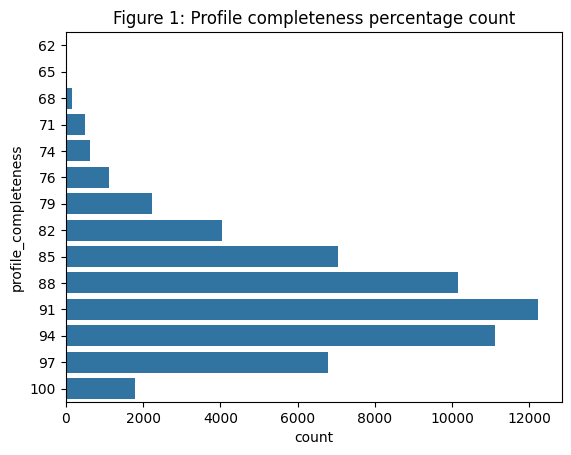

In [120]:
sns.countplot(y = 'profile_completeness',data = df_clean).set_title('Figure 1: Profile completeness percentage count')

**Finding on Completeness** - Income being the highest not being disclosed which is understood. 
But,  here we also have columns being empty by the users like Diet choices, partner trait choices, etc in the top 10 columns, which are crucial for the dating application.


Top 5 non-essys columns for *No response, unknowns or "0"* **Overall**, are mostly same for both the gender - 
1. Income
2. Offspring
3. Diet
4. Religion
5. Drugs


**User on average were completing 80%, which is good for a dating app!**

In [121]:
df_completeness = df_clean.copy()

In [122]:
df_completeness = df_completeness.drop(columns = ['essay0', 'essay1', 'essay2','essay3',\
                            'essay4','essay5','essay6','essay7','essay8',\
                            'essay9'], axis=1)

In [123]:
unknown_counts = []
for c in df_completeness.columns:
    combined_count = ((df_completeness[c] == 'unknown') | (df_completeness[c] == 0) | (df_completeness[c] == 'No response')).sum()
    unknown_counts.append((c, combined_count))

In [124]:
unknown_counts_df = pd.DataFrame(unknown_counts, columns=['Column', 'Count'])

In [125]:
unknown_counts_df.columns

Index(['Column', 'Count'], dtype='object')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 1.0, 'Figure2: Columns - unknowns Count')

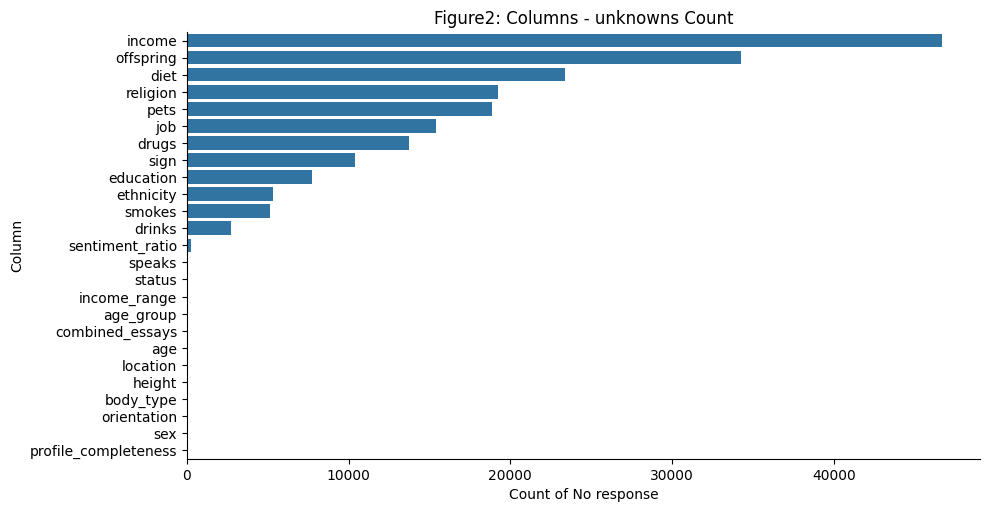

In [126]:
sns.catplot(x='Count', y='Column',kind='bar', data=unknown_counts_df.sort_values('Count', ascending=False),aspect = 2)
plt.xlabel('Count of No response')
plt.ylabel('Column')
plt.title('Figure2: Columns - unknowns Count')

<Axes: xlabel='count', ylabel='offspring'>

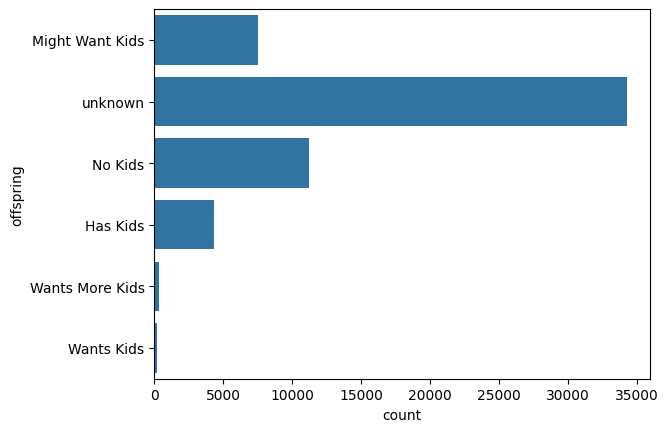

In [127]:
sns.countplot(y = 'offspring',data = df_completeness)

<Axes: xlabel='count', ylabel='religion'>

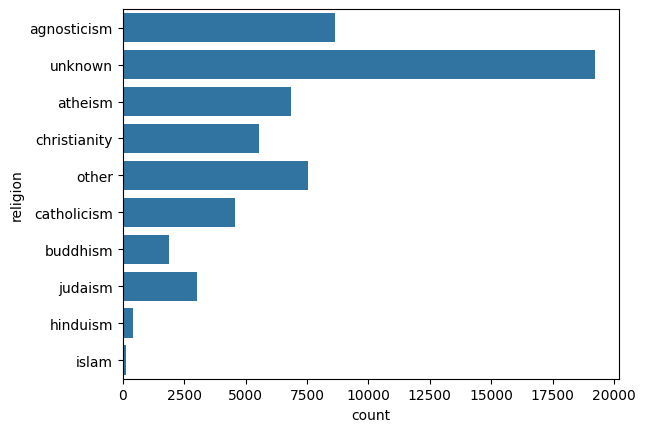

In [128]:
sns.countplot(y = 'religion',data = df_completeness)

<Axes: xlabel='count', ylabel='pets'>

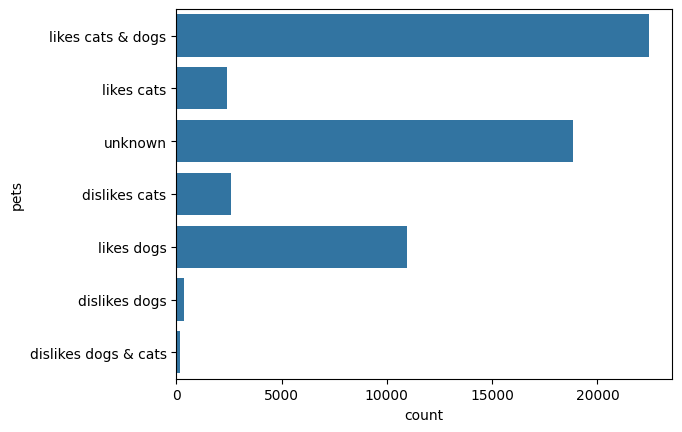

In [129]:
sns.countplot(y = 'pets',data = df_completeness)

<Axes: xlabel='count', ylabel='job'>

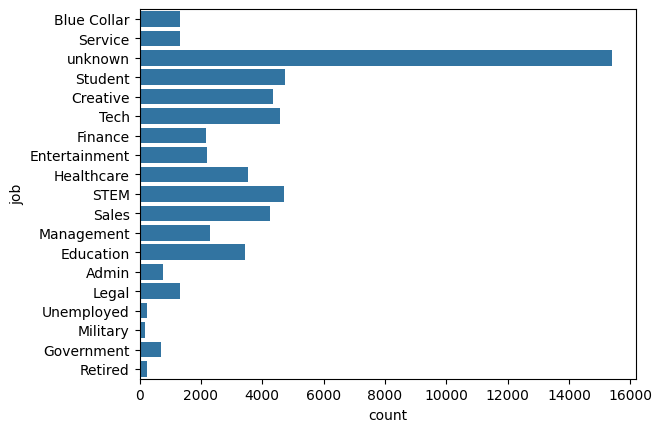

In [130]:
sns.countplot(y = 'job',data = df_completeness)

**Finding – Even people who are filling up these columns are picking up generic choices and preferences to get more matches.**

### Managerial Suggession: Profile Completion Insights
### Application Observation(Testing): 
Top columns with 100% completion, are mandate columns of the App, while creation of the app.

1. Age
2. Status
3. Sex
4. Orientation

We have prefer not to say option in the following field(columns) -

1. Body Type
2. Height
3. Languages
4. Ethnicity
5. Religion
6. Education
7. Employment /Jobs
8. Sign
9. Drinks
10. Smoking
11. Drugs
12. Diet
13. Children

Multiple Choices with prefer not to say option -
1. Pets
2. Languages / Speaks
3. Ethnicity

### As per Data Analysis - 
1. Out of 16 columns, users' top non-essys columns for No response, unknowns or "0" are - 
    1. Offspring
    2. Diet
    3. Religion
    4. Pets
    5. Job

2. Male and Female, both have same proportion of profile completion rate. 



### Improvement Action:
Managerial Recommendation: 
As per the tagline *We connect you on what matters*, profile completeness and their legitimacy is necessary. To accomplish this on the application. 

2. **GenAI Recommendation** To improve & complete personal profile
3. **Include features to add legitimacy of the profile**  Matches can highlight specifics
4. **Leveraging metadata for benefits** - e.g. hotel discounts for wanderers